# 04 SER with ReserveBonus

---
## 0. Setup

In [1]:
import numpy as np
np.set_printoptions(precision=3)  # 数値桁数を指定．
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

import importlib
import itertools

import sys
sys.path.append('../../RLPack')
sys.path.append('../')

---
## 1. Environment

In [2]:
import Env_Reserve_RB
importlib.reload(Env_Reserve_RB)

<module 'Env_Reserve_RB' from '/media/deepstation/strage01/Actuary/2019/20191107_Reserve_SER_RB/Env_Reserve_RB.py'>

In [3]:
cashflow = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, -10])
interest = 0.01
hurdle = 0.05
initial_cash = 15
bankrupt_penalty = -50
bankrupt_info = False

env = Env_Reserve_RB.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=bankrupt_info, 
                              n_agents=64)

---
## 2. Normal

In [4]:
env = Env_Reserve_RB.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=bankrupt_info, 
                              n_agents=64)

n_trials = 5
n_steps = 50000

df = pd.DataFrame()

---
### DQN

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W1108 23:24:38.629548 140184961824576 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 23:24:38.630283 140184961824576 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 23:24:38.633711 

lr=0.001, eps=0.5, boltzmann=False
start testing... :  2019-11-08 23:24:38.764680
start trial 1/5 trial...


W1108 23:24:39.126980 140184961824576 deprecation_wrapper.py:119] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

  0%|          | 0/50000 [00:00<?, ?it/s]

start trial 2/5 trial...


100%|██████████| 50000/50000 [05:37<00:00, 145.94it/s]


start trial 3/5 trial...


100%|██████████| 50000/50000 [05:52<00:00, 141.83it/s]


start trial 4/5 trial...


100%|██████████| 50000/50000 [06:05<00:00, 131.72it/s]


start trial 5/5 trial...


100%|██████████| 50000/50000 [06:21<00:00, 129.30it/s]


end testing... :  2019-11-08 23:54:06.563190
loss and reward history


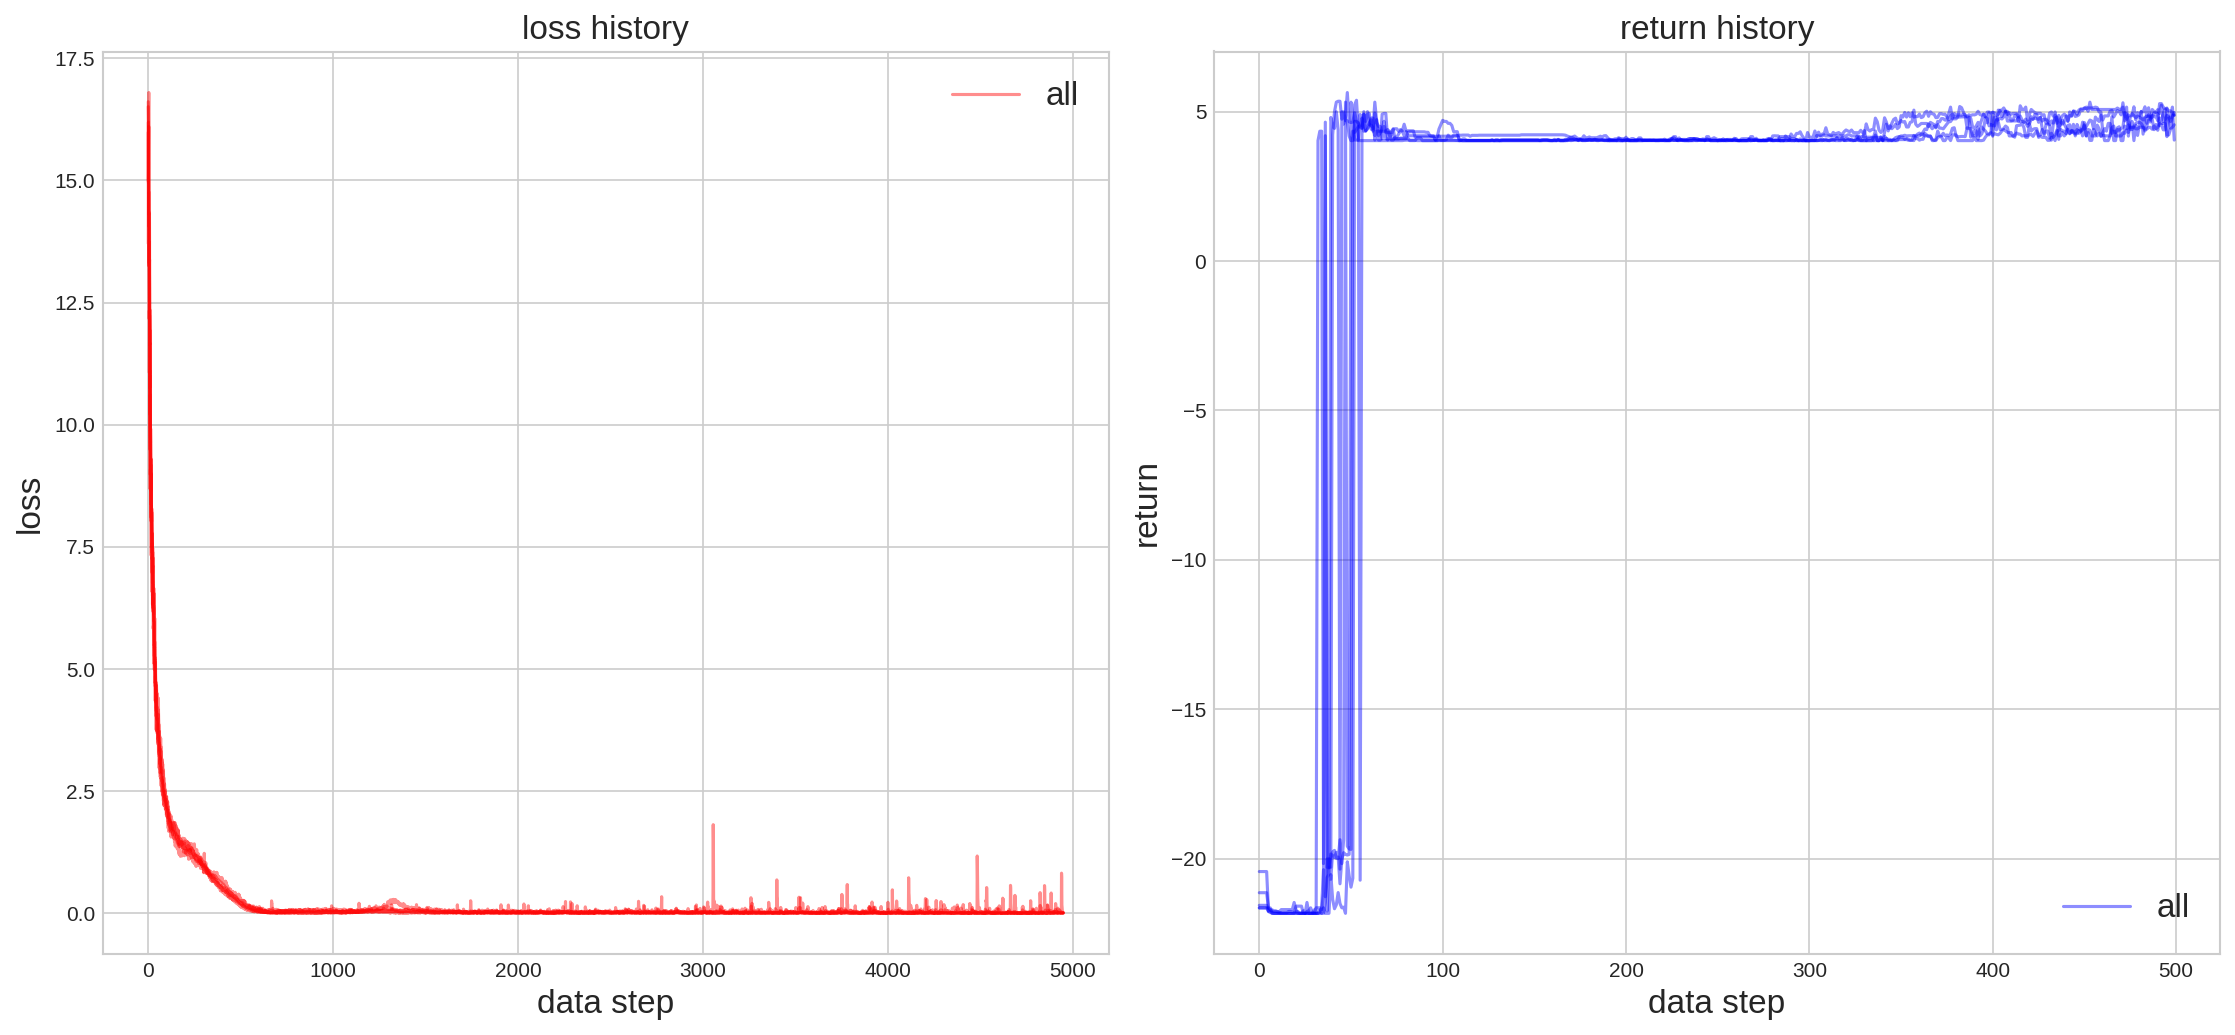

acquired action
action =  [14 14 14 14 14 14 14 14 14 14]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [13 13 13 13 13 13 13 13 13 13]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [11 11 11 11 11 11 11 11 11 11]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [12 12 12 12 12 12 12 12 12 12]
return [4.873 4.873 4.873 4.873 4.873 4.873 4.873 4.873 4.873 4.873]
param distribution in model


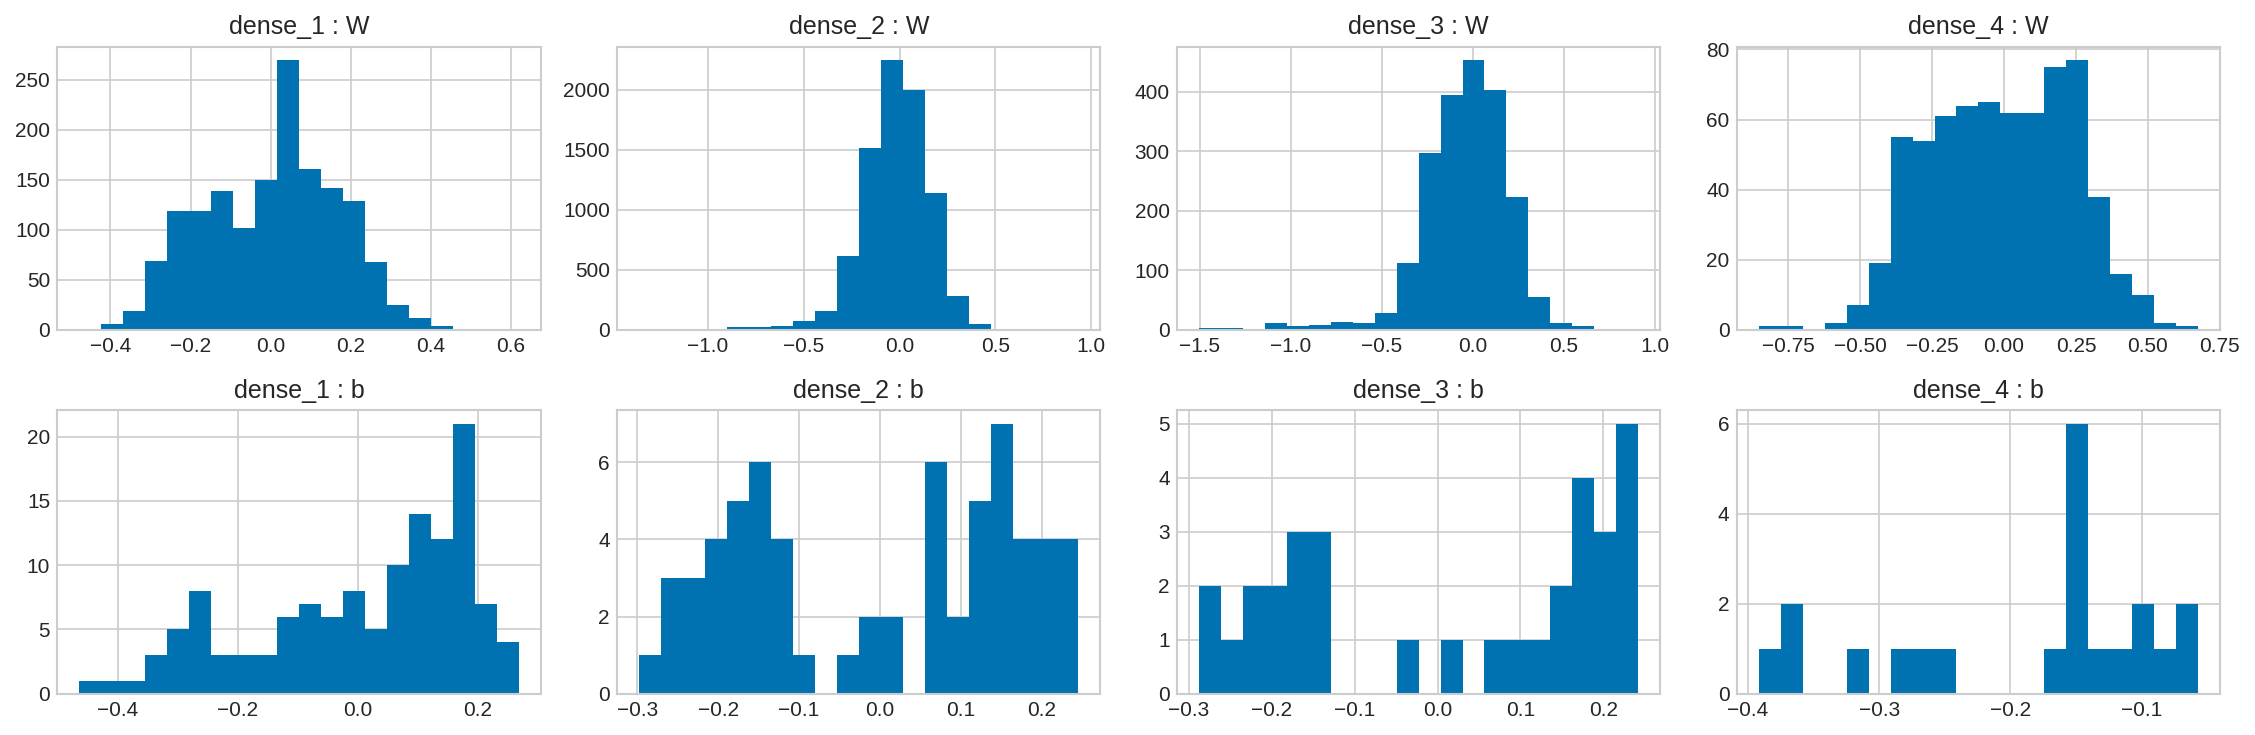

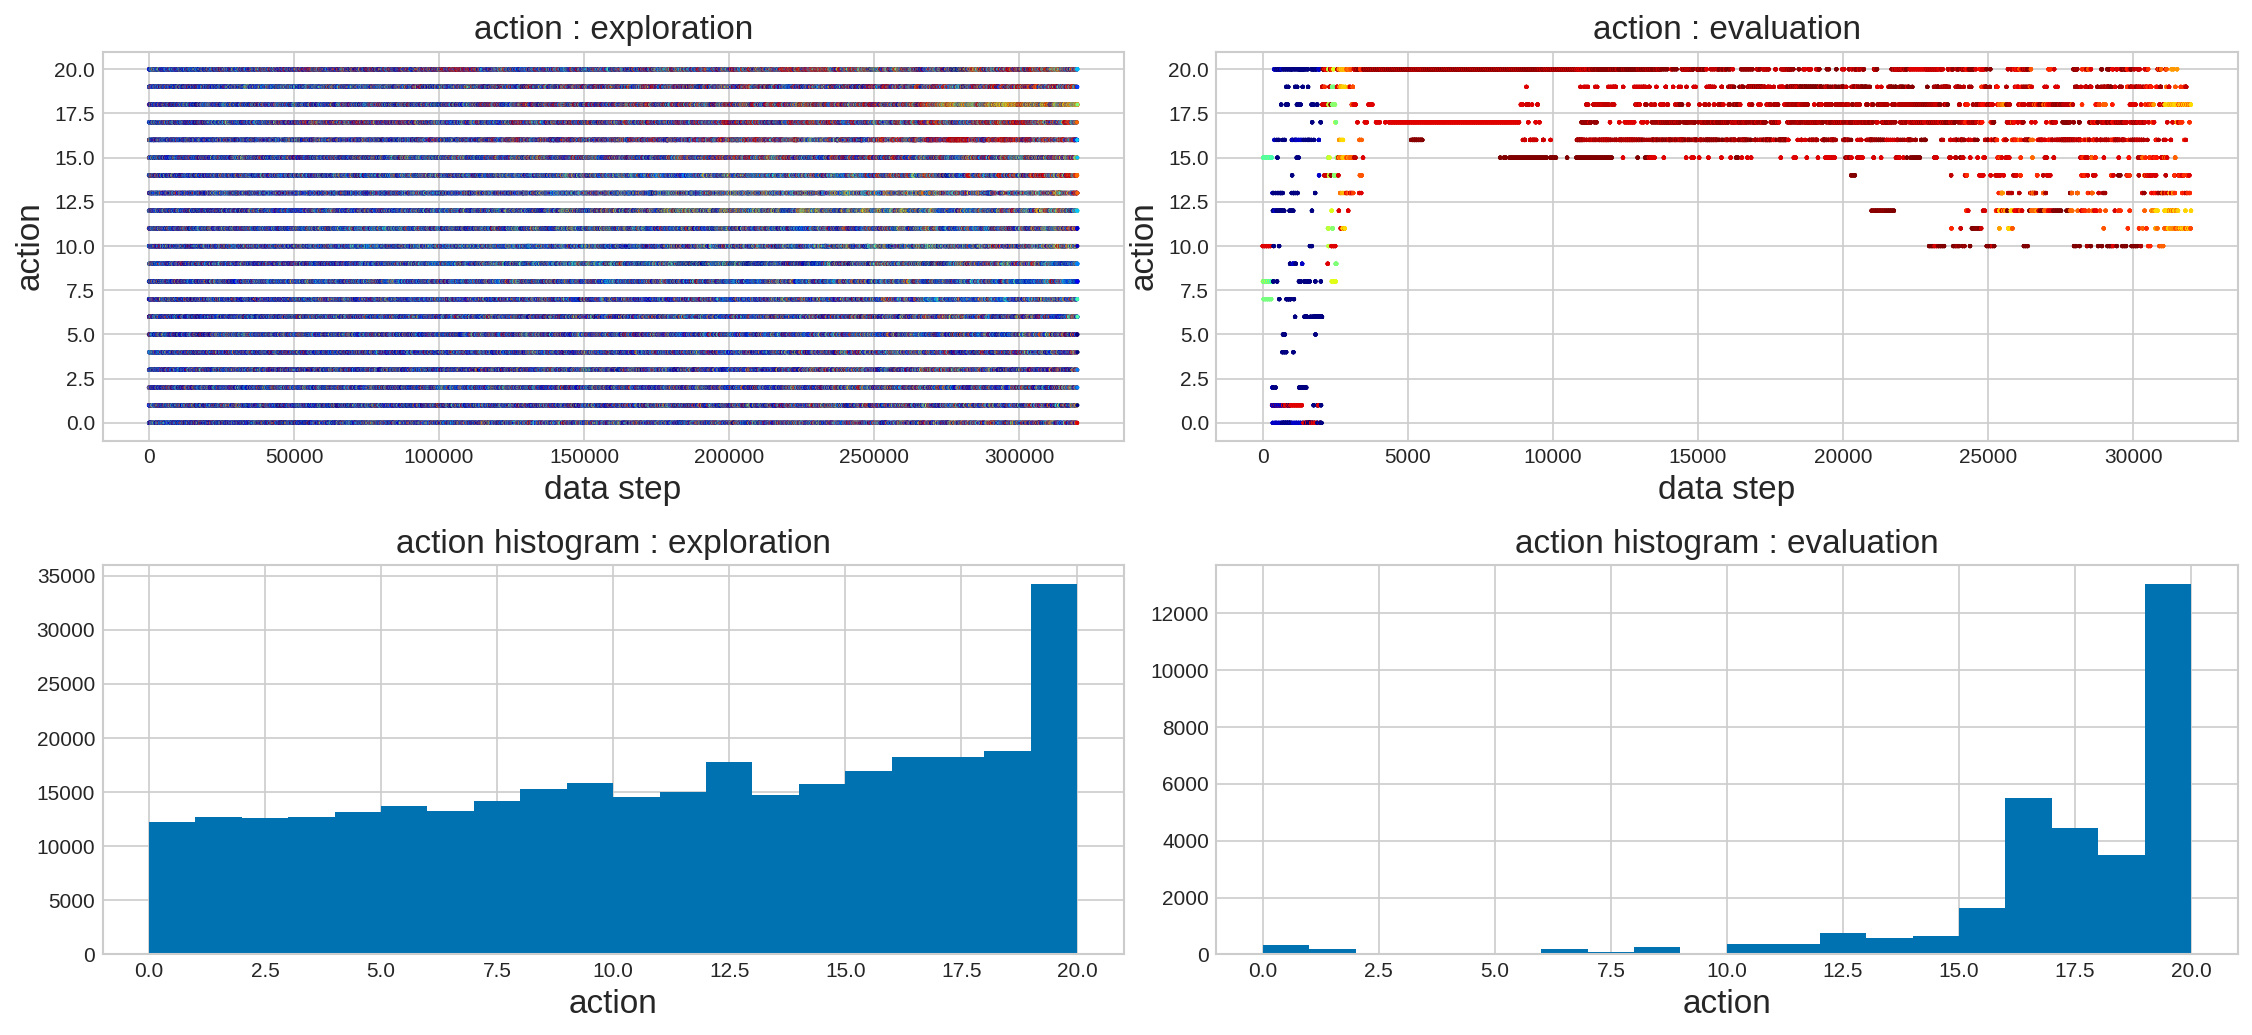

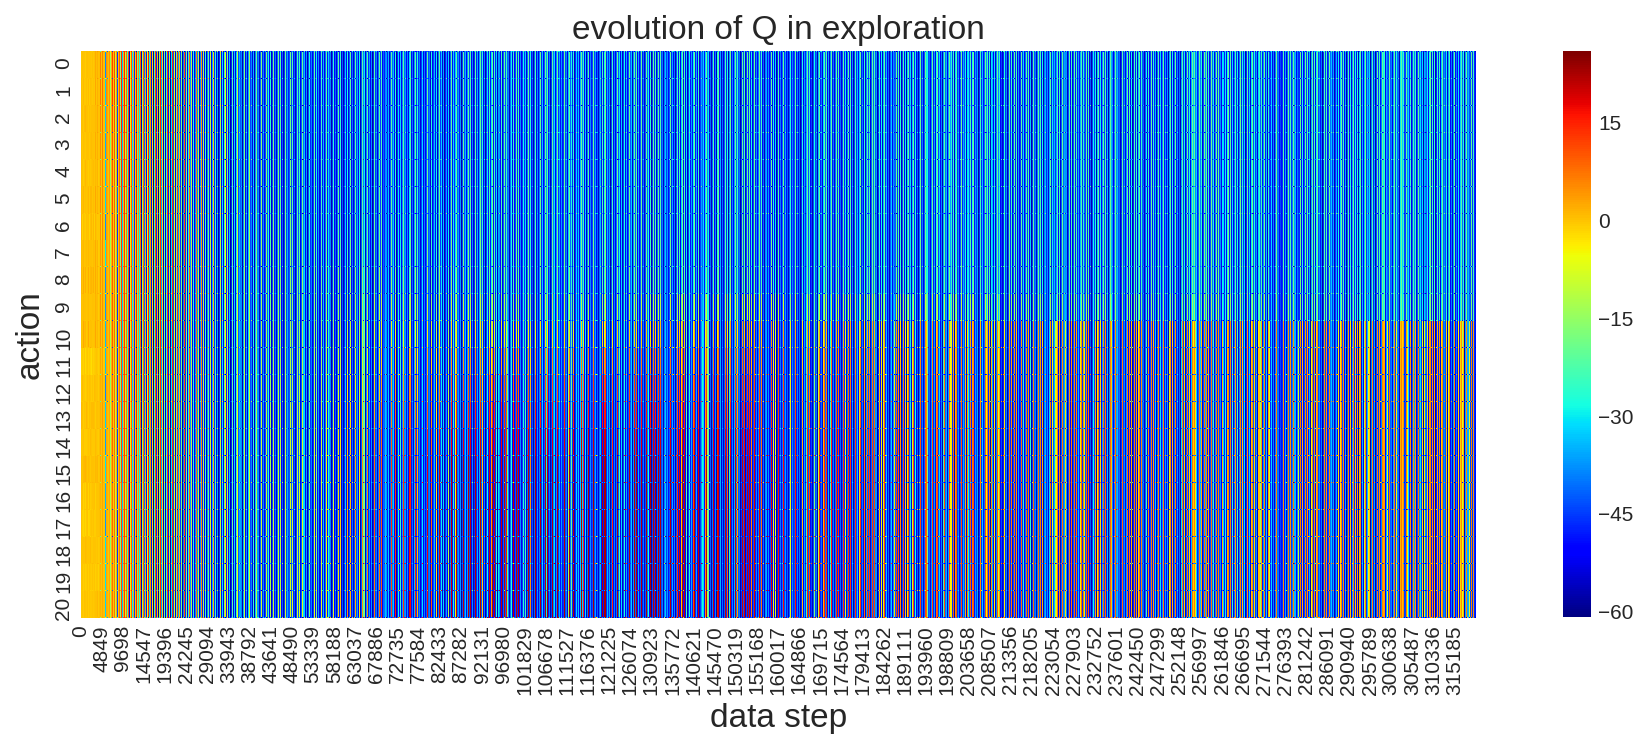

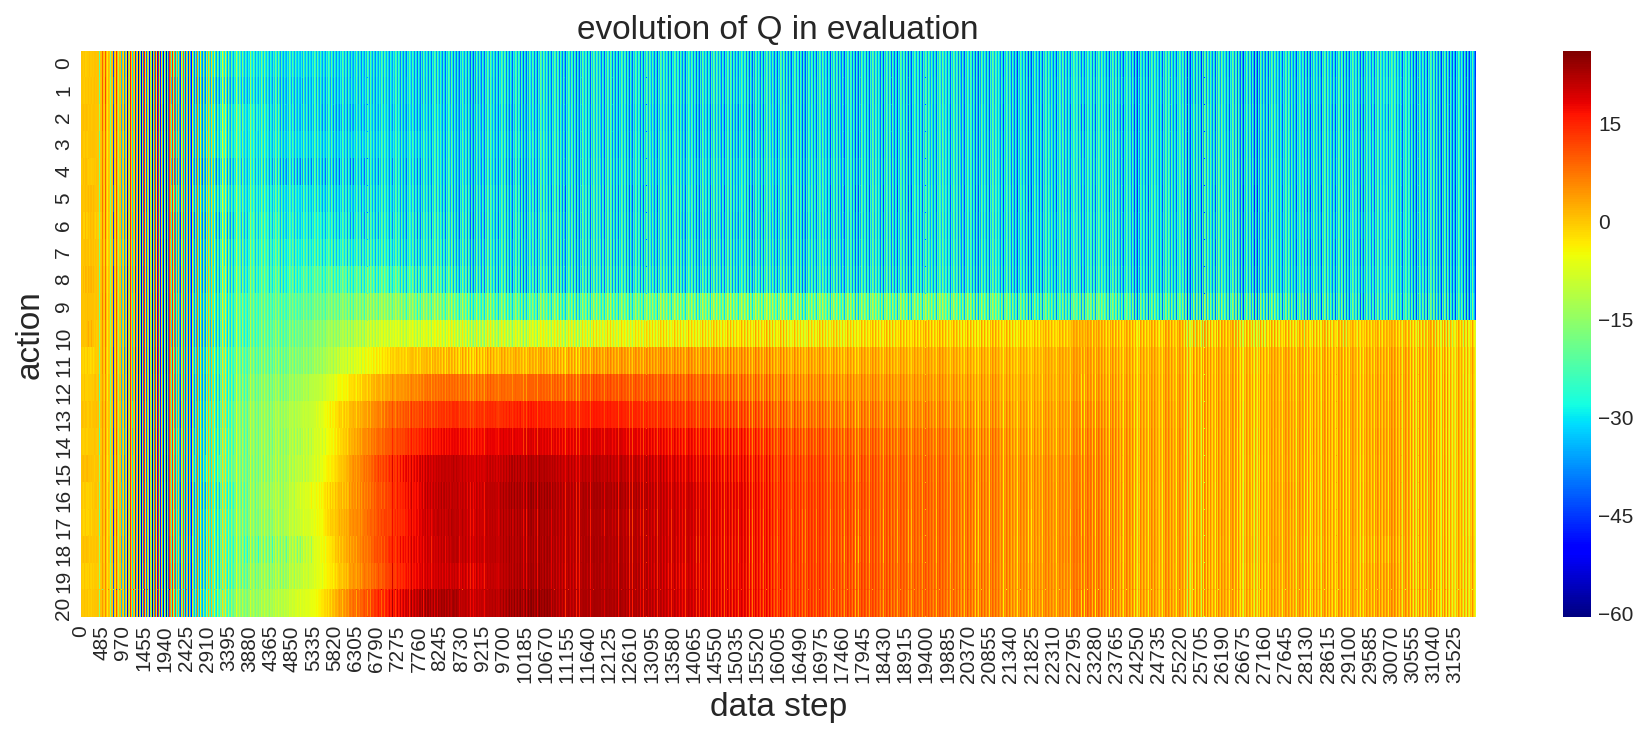

bankrupt=1584438, total=1760064, ratio=0.9002


In [5]:
import DQN
import importlib
importlib.reload(DQN)  # original DRL code
from keras import optimizers

model = DQN.gen_model(input_shapes=env.shapes(), n_outputs=21, \
                           hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                           duel=False, duel_value_dim=8, duel_advantage_dim=16, 
                           input_reg=False, input_min=0, input_max=1,
                           output_reg=False, output_min=0, output_max=1)

#df = pd.DataFrame()
for lr, eps, boltzmann in itertools.product([1e-3,], [0.5,], [False,]):
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}'
          .format(lr, eps, boltzmann))
    
    tester = DQN.Tester(env, model)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=10, n_batches=10, batch_size=256, alpha=1.0, 
                target_update_interval=20, doubleQ=False,
                gamma=1.0/(1+hurdle), optimizer=optimizers.Adam(lr),
                epsilon_start=1.0, epsilon_end=eps, epsilon_interval=n_steps,
                boltzmann=boltzmann, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = DQN.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        df_temp['Agent'] = 'DQN'

        df = pd.concat([df, df_temp])

    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

lr=0.001, eps=0.5, boltzmann=False, n_advantages=4, bankrupt_info=True
start testing... :  2019-11-08 23:54:37.637270
start trial 0/5 trial...


100%|██████████| 50000/50000 [06:48<00:00, 122.32it/s]


start trial 1/5 trial...


100%|██████████| 50000/50000 [06:54<00:00, 120.57it/s]


start trial 2/5 trial...


100%|██████████| 50000/50000 [06:59<00:00, 102.00it/s]


start trial 3/5 trial...


100%|██████████| 50000/50000 [07:02<00:00, 118.27it/s]


start trial 4/5 trial...


100%|██████████| 50000/50000 [07:07<00:00, 116.92it/s]


end testing... :  2019-11-09 00:29:37.913077
loss and reward history


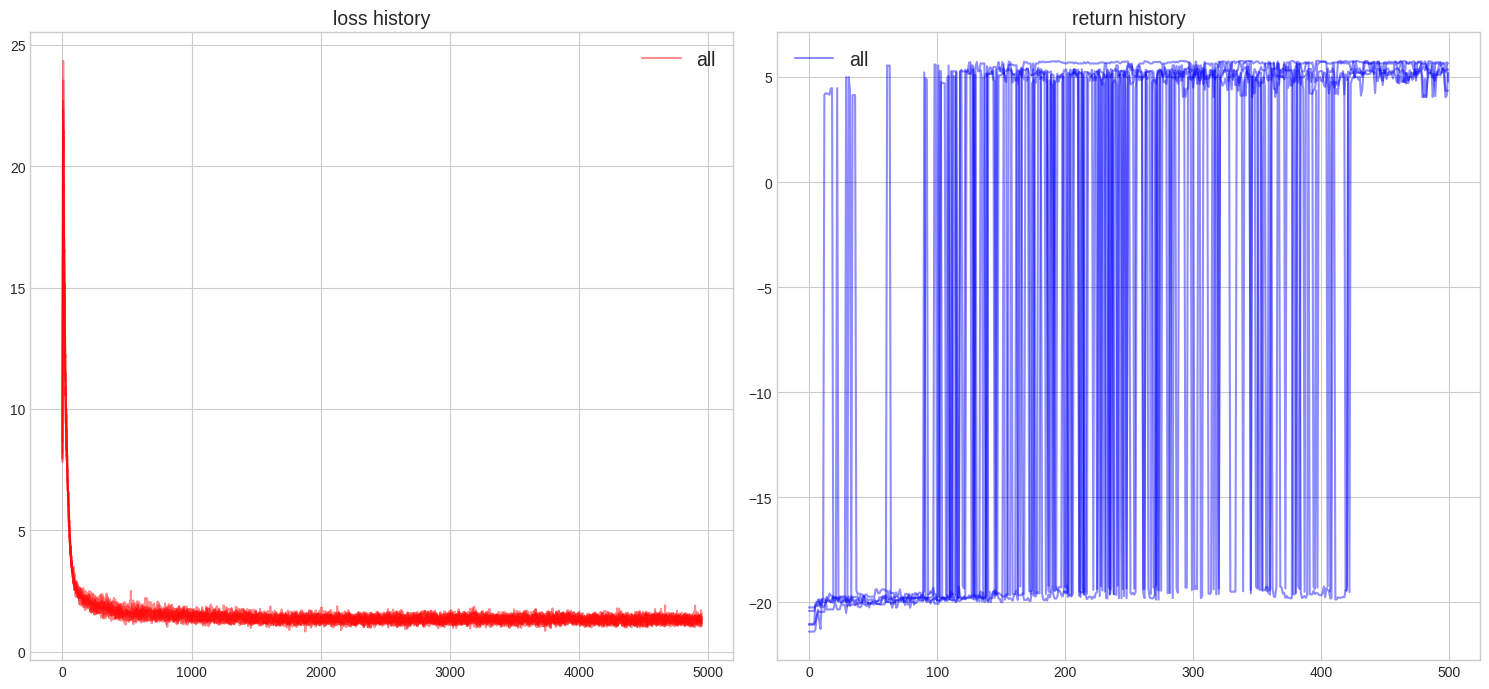

acquired action
action =  [10 10 10 10 10 10 10 10 10 10]
action =  [20 20 20 20 20 20 20 20 20 20]
action =  [20 20 20 20 20 20 20 20 20 20]
action =  [18 18 18 18 18 18 18 18 18 18]
action =  [16 16 16 16 16 16 16 16 16 16]
action =  [16 16 16 16 16 16 16 16 16 16]
action =  [17 17 17 17 17 17 17 17 17 17]
action =  [16 16 16 16 16 16 16 16 16 16]
action =  [16 16 16 16 16 16 16 16 16 16]
action =  [16 16 16 16 16 16 16 16 16 16]
return [5.642 5.642 5.642 5.642 5.642 5.642 5.642 5.642 5.642 5.642]
param distribution in model


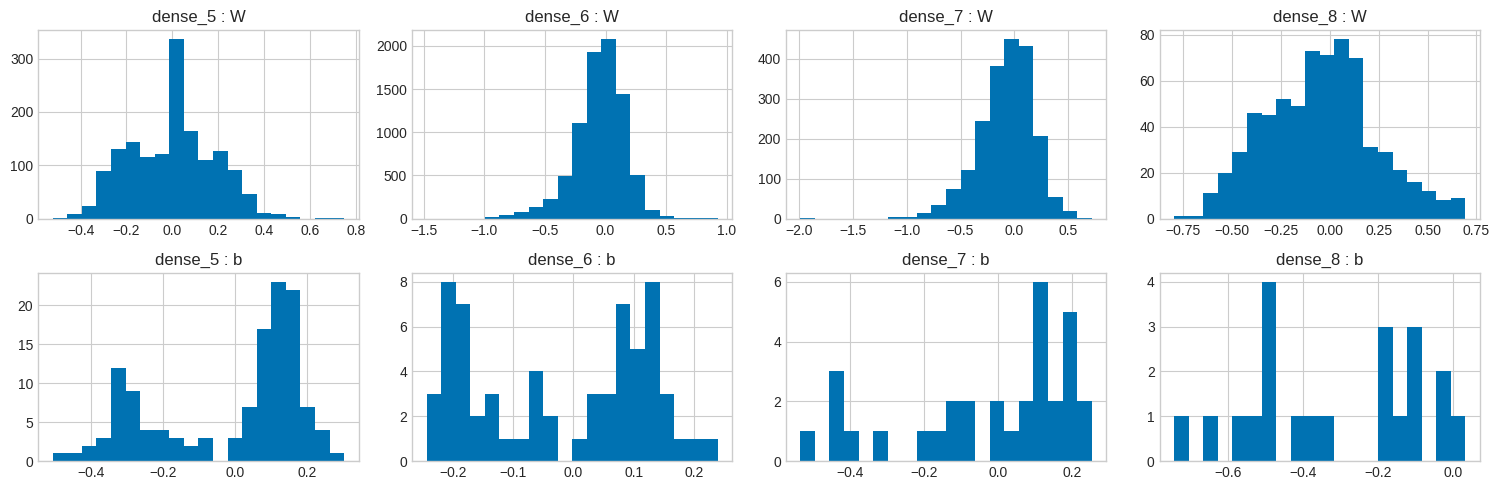

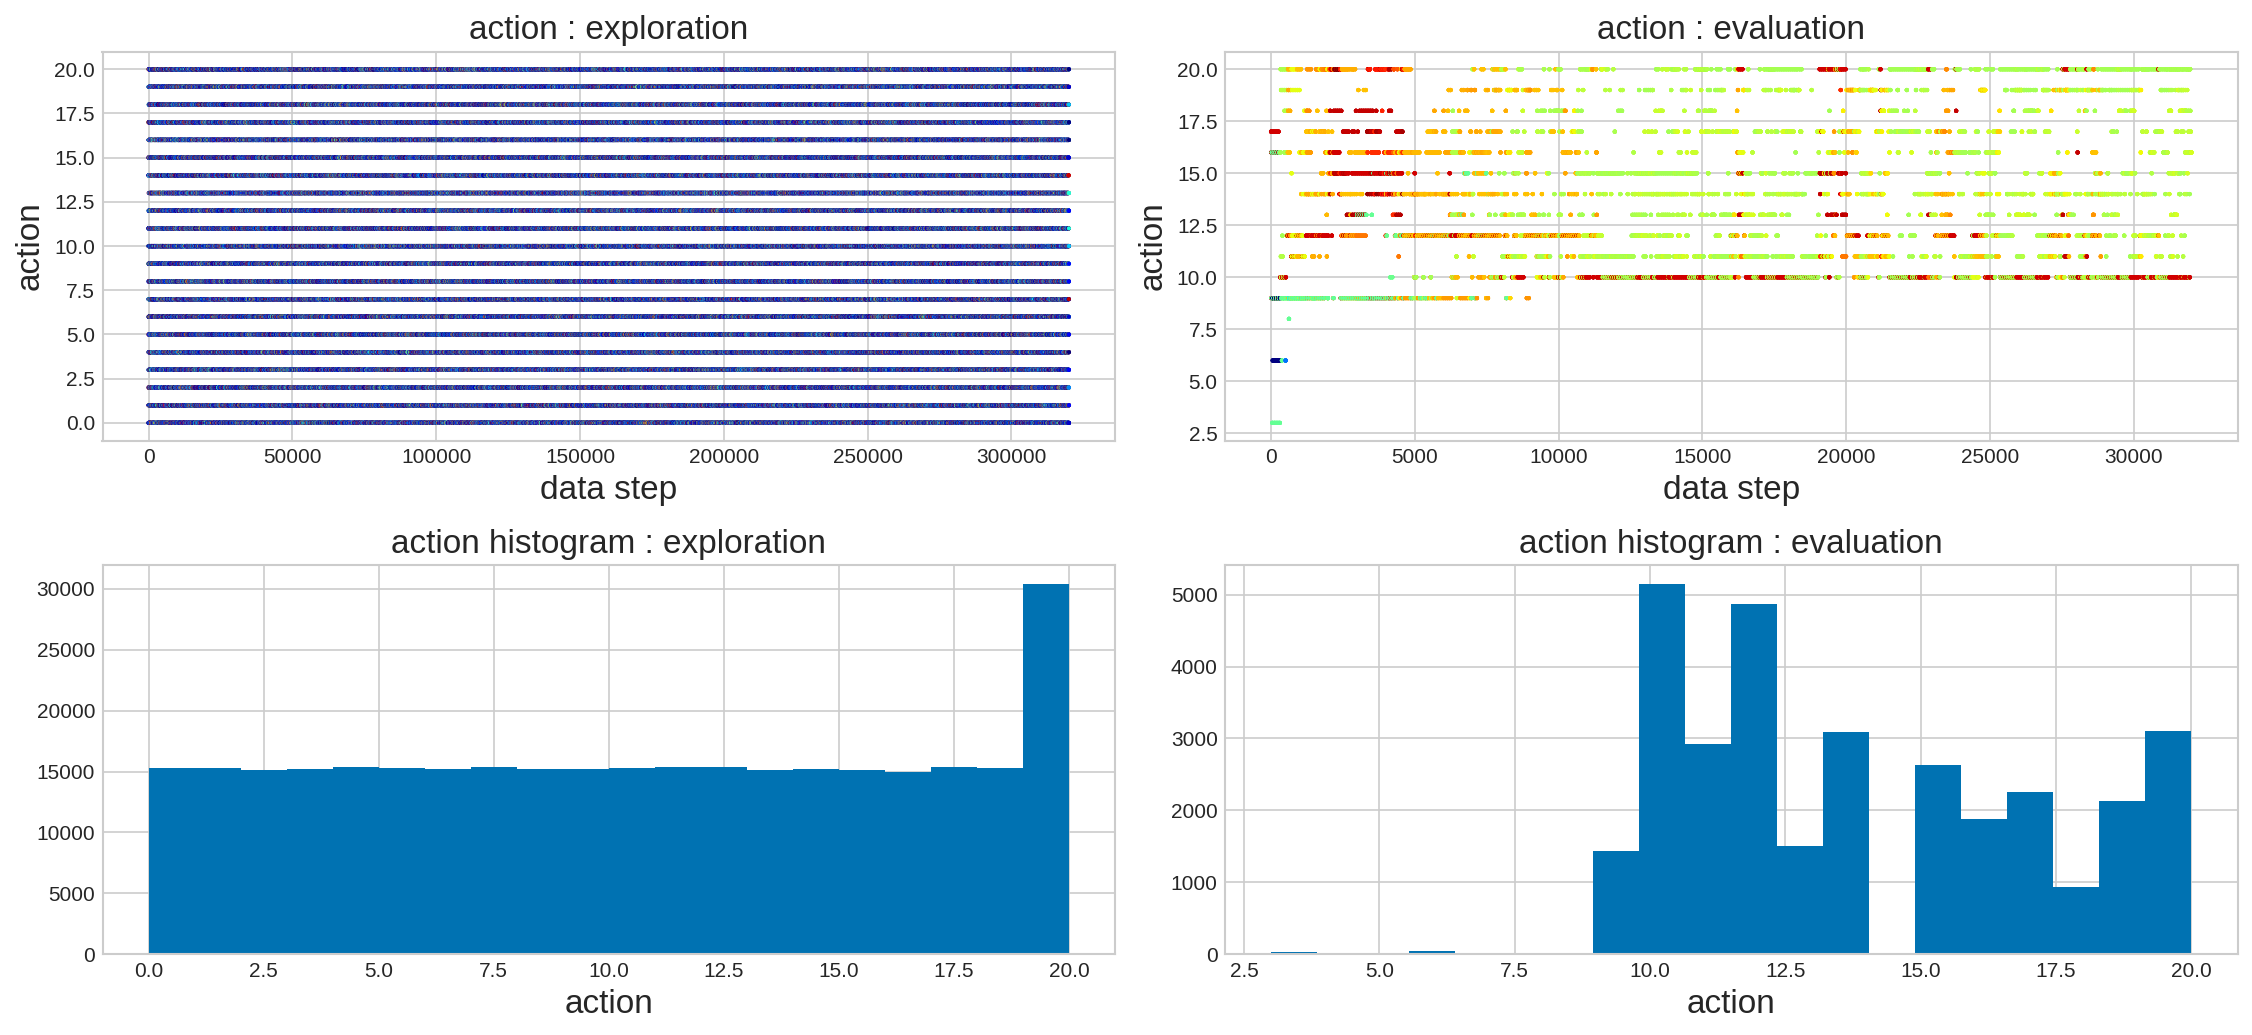

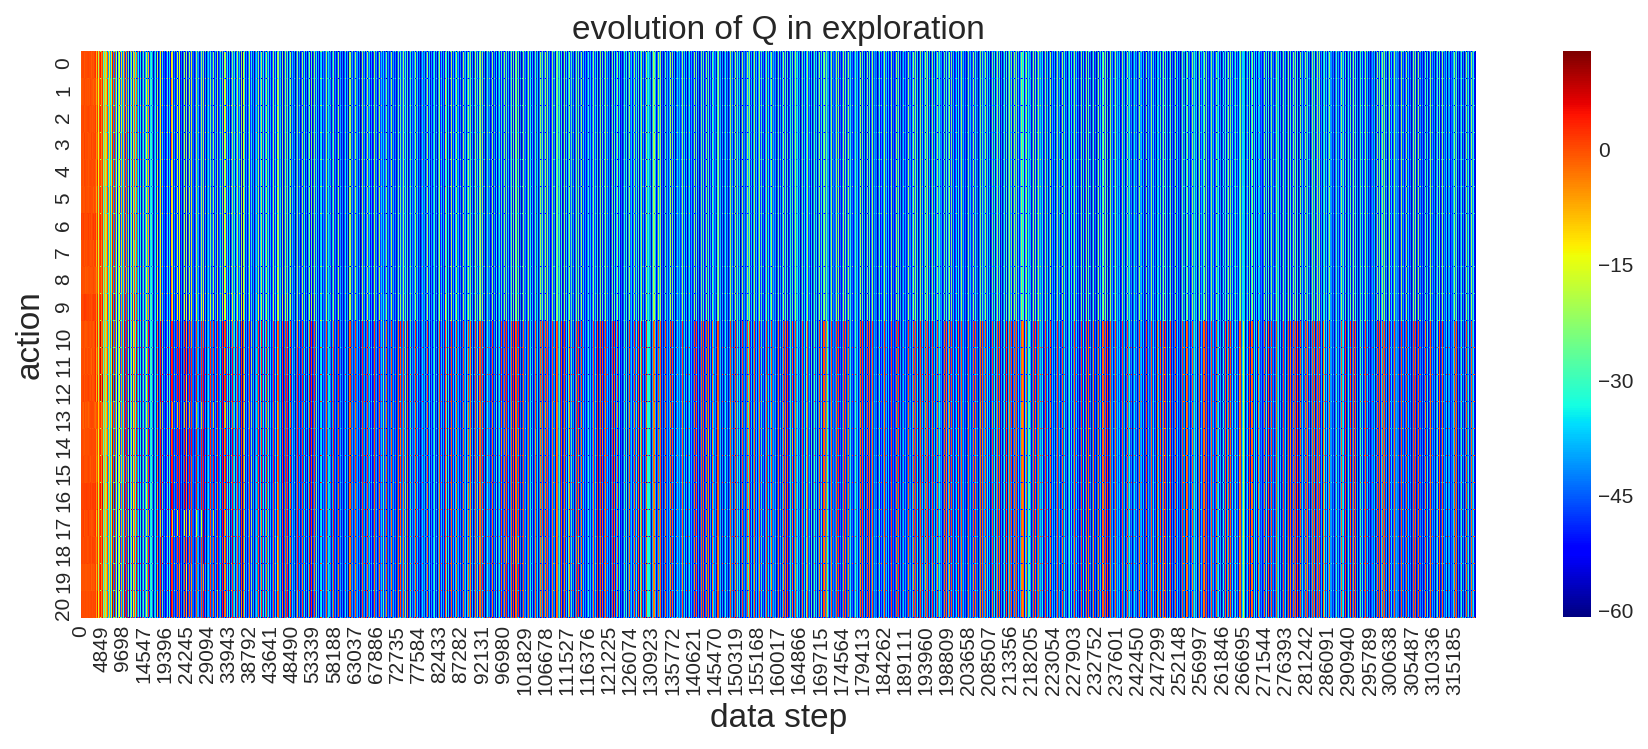

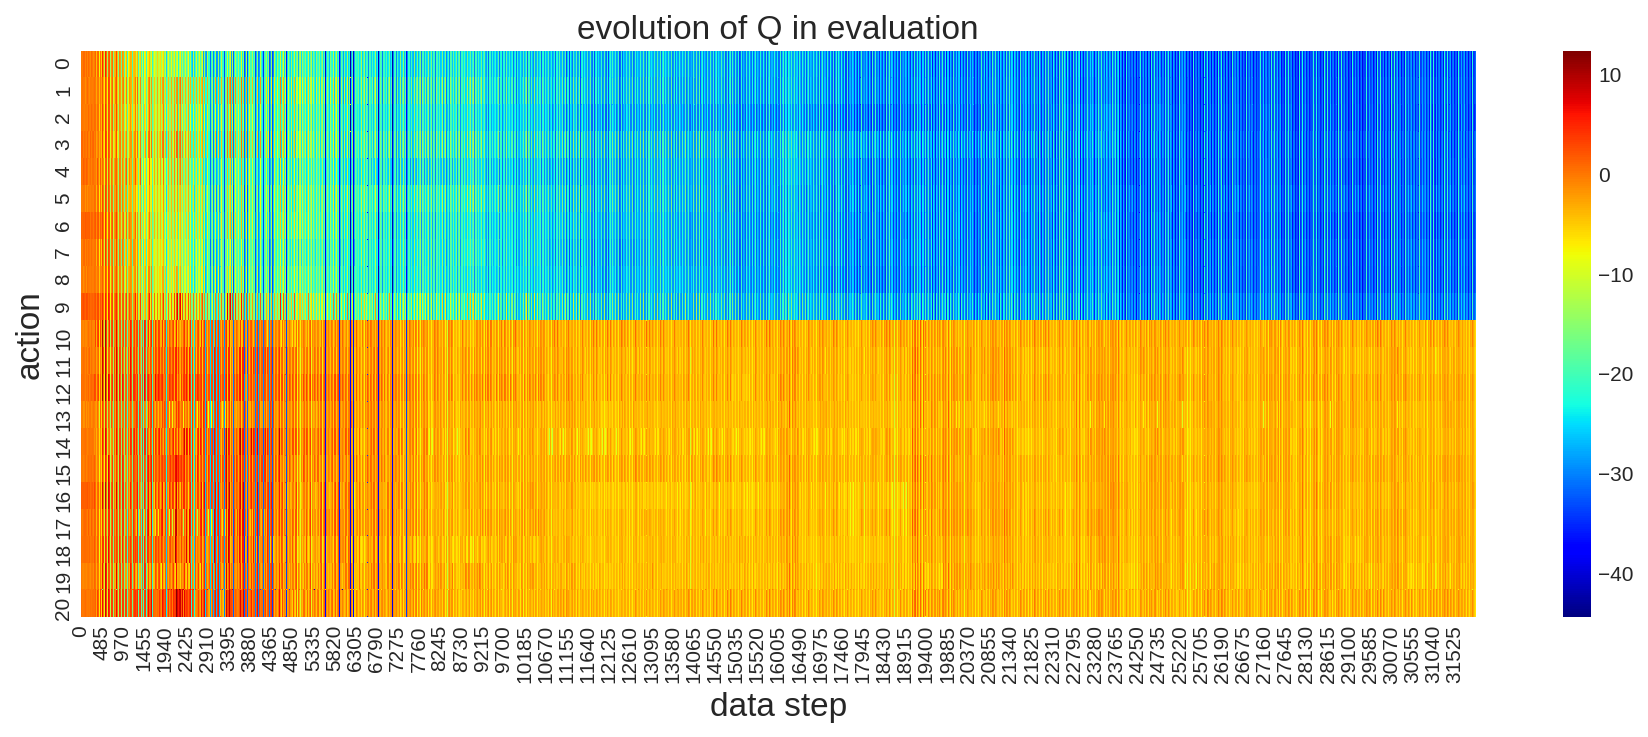

bankrupt=1656460, total=1760064, ratio=0.9411


In [6]:
import DQN_SER  # original DRL code
importlib.reload(DQN_SER)
from keras import optimizers

#df = pd.DataFrame()
for lr, eps, boltzmann, n_advantages, bankrupt_info in itertools.product([1e-3], [0.5], [False], [4], [True]):
    eps *= 10.0 if boltzmann else 1.0
    print('======================================================')
    print('lr={}, eps={}, boltzmann={}, n_advantages={}, bankrupt_info={}'
          .format(lr, eps, boltzmann, n_advantages, bankrupt_info))
    
    env = Env_Reserve_RB.Environment(cashflow=cashflow, 
                                  interest=interest, hurdle=hurdle, 
                                  initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                                  bankrupt_info=True, 
                                  n_agents=64)

    model = DQN_SER.gen_model(input_shapes=env.shapes(), n_outputs=21, 
                              hidden_dims=[128, 64, 32], reg_l1=0.0, reg_l2=0.0, 
                              duel=False, duel_value_dim=16, duel_advantage_dim=64, 
                              output_reg=False, output_min=0, output_max=1)

    tester = DQN_SER.Tester(env, model)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps,
                training_interval=10, n_batches=10, batch_size=256, 
                alpha=1.0, target_update_interval=20, 
                doubleQ=False,
                gamma=1.0/(1+hurdle), 
                optimizer=optimizers.Adam(lr, clipnorm=10.0, clipvalue=10.0),
                epsilon_start=10.0 if boltzmann else 1.0, epsilon_end=eps, epsilon_interval=n_steps, 
                boltzmann=boltzmann, 
                warmup_steps=500,
                verbose=False, verbose_interval=10, evaluate_interval=100,
                n_advantages=n_advantages, 
                category_weights={'bankrupt':0.5, 'ok':0.5}, default_weight=1.0, 
                get_log=True, 
                )
    
    viz = DQN_SER.Visualizer()
    viz.viz_action_history(tester.trainer, lambda x:x[0], 
                           cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(tester.trainer)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['eps'] = eps
        #df_temp['boltzmann'] = boltzmann
        #df_temp['n_advantages'] = n_advantages
        #df_temp['bankrupt_info'] = bankrupt_info
        df_temp['Agent'] = 'DQN_SER'

        df = pd.concat([df, df_temp])
        
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0
    
df.to_csv(tester.name + '.csv')

---
### DDPG

In [7]:
mu_min = 0.0
mu_max = 20.0

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=10
start testing... :  2019-11-09 00:30:10.571459
start 0/5 th trial...


100%|██████████| 50000/50000 [19:48<00:00, 42.08it/s]


start 1/5 th trial...


100%|██████████| 50000/50000 [20:18<00:00, 41.04it/s]


start 2/5 th trial...


100%|██████████| 50000/50000 [20:36<00:00, 26.84it/s]


start 3/5 th trial...


100%|██████████| 50000/50000 [21:29<00:00, 28.09it/s]


start 4/5 th trial...


100%|██████████| 50000/50000 [21:59<00:00, 37.88it/s]


end testing... :  2019-11-09 02:14:46.020159
loss and reward history


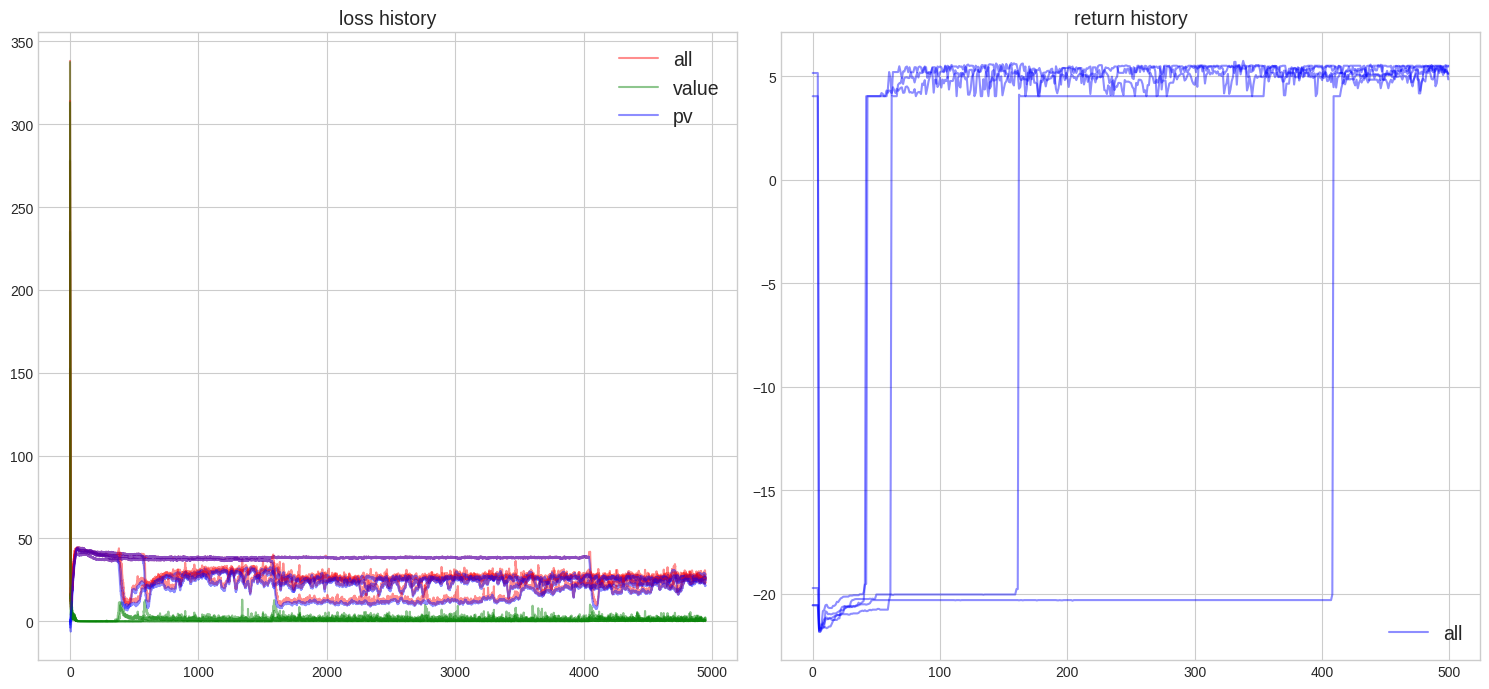

acquired action
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [10.318 10.318 10.318 10.318 10.318 10.318 10.318 10.318 10.318 10.318]
action =  [13.67 13.67 13.67 13.67 13.67 13.67 13.67 13.67 13.67 13.67]
action =  [13.733 13.733 13.733 13.733 13.733 13.733 13.733 13.733 13.733 13.733]
action =  [17.548 17.548 17.548 17.548 17.548 17.548 17.548 17.548 17.548 17.548]
action =  [10.534 10.534 10.534 10.534 10.534 10.534 10.534 10.534 10.534 10.534]
action =  [14.294 14.294 14.294 14.294 14.294 14.294 14.294 14.294 14.294 14.294]
action =  [15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261]
action =  [14.93 14.93 14.93 14.93 14.93 14.93 14.93 14.93 14.93 14.93]
action =  [14.827 14.827 14.827 14.827 14.827 14.827 14.827 14.827 14.827 14.827]
return [5.48 5.48 5.48 5.48 5.48 5.48 5.48 5.48 5.48 5.48]
param distribution in model_policy


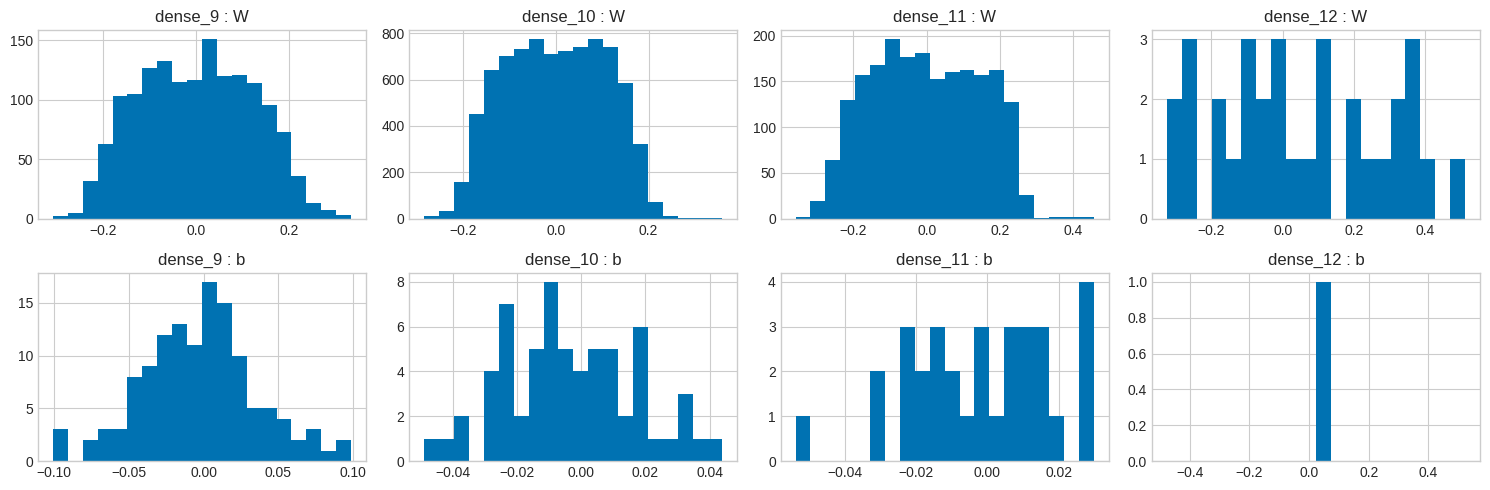

param distribution in model_value


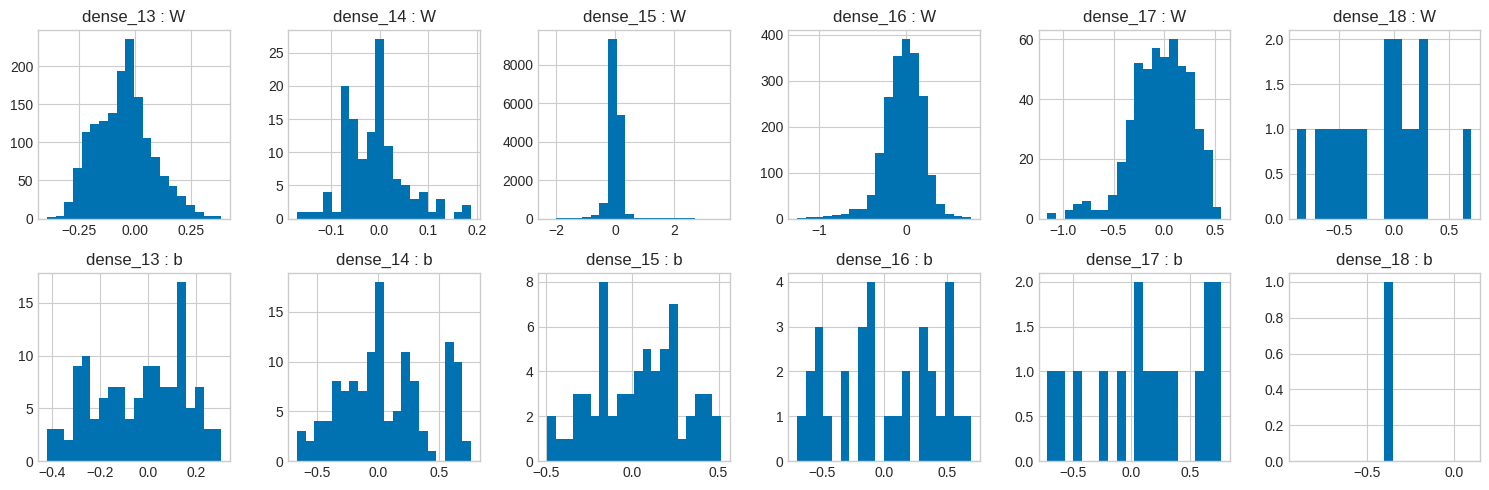

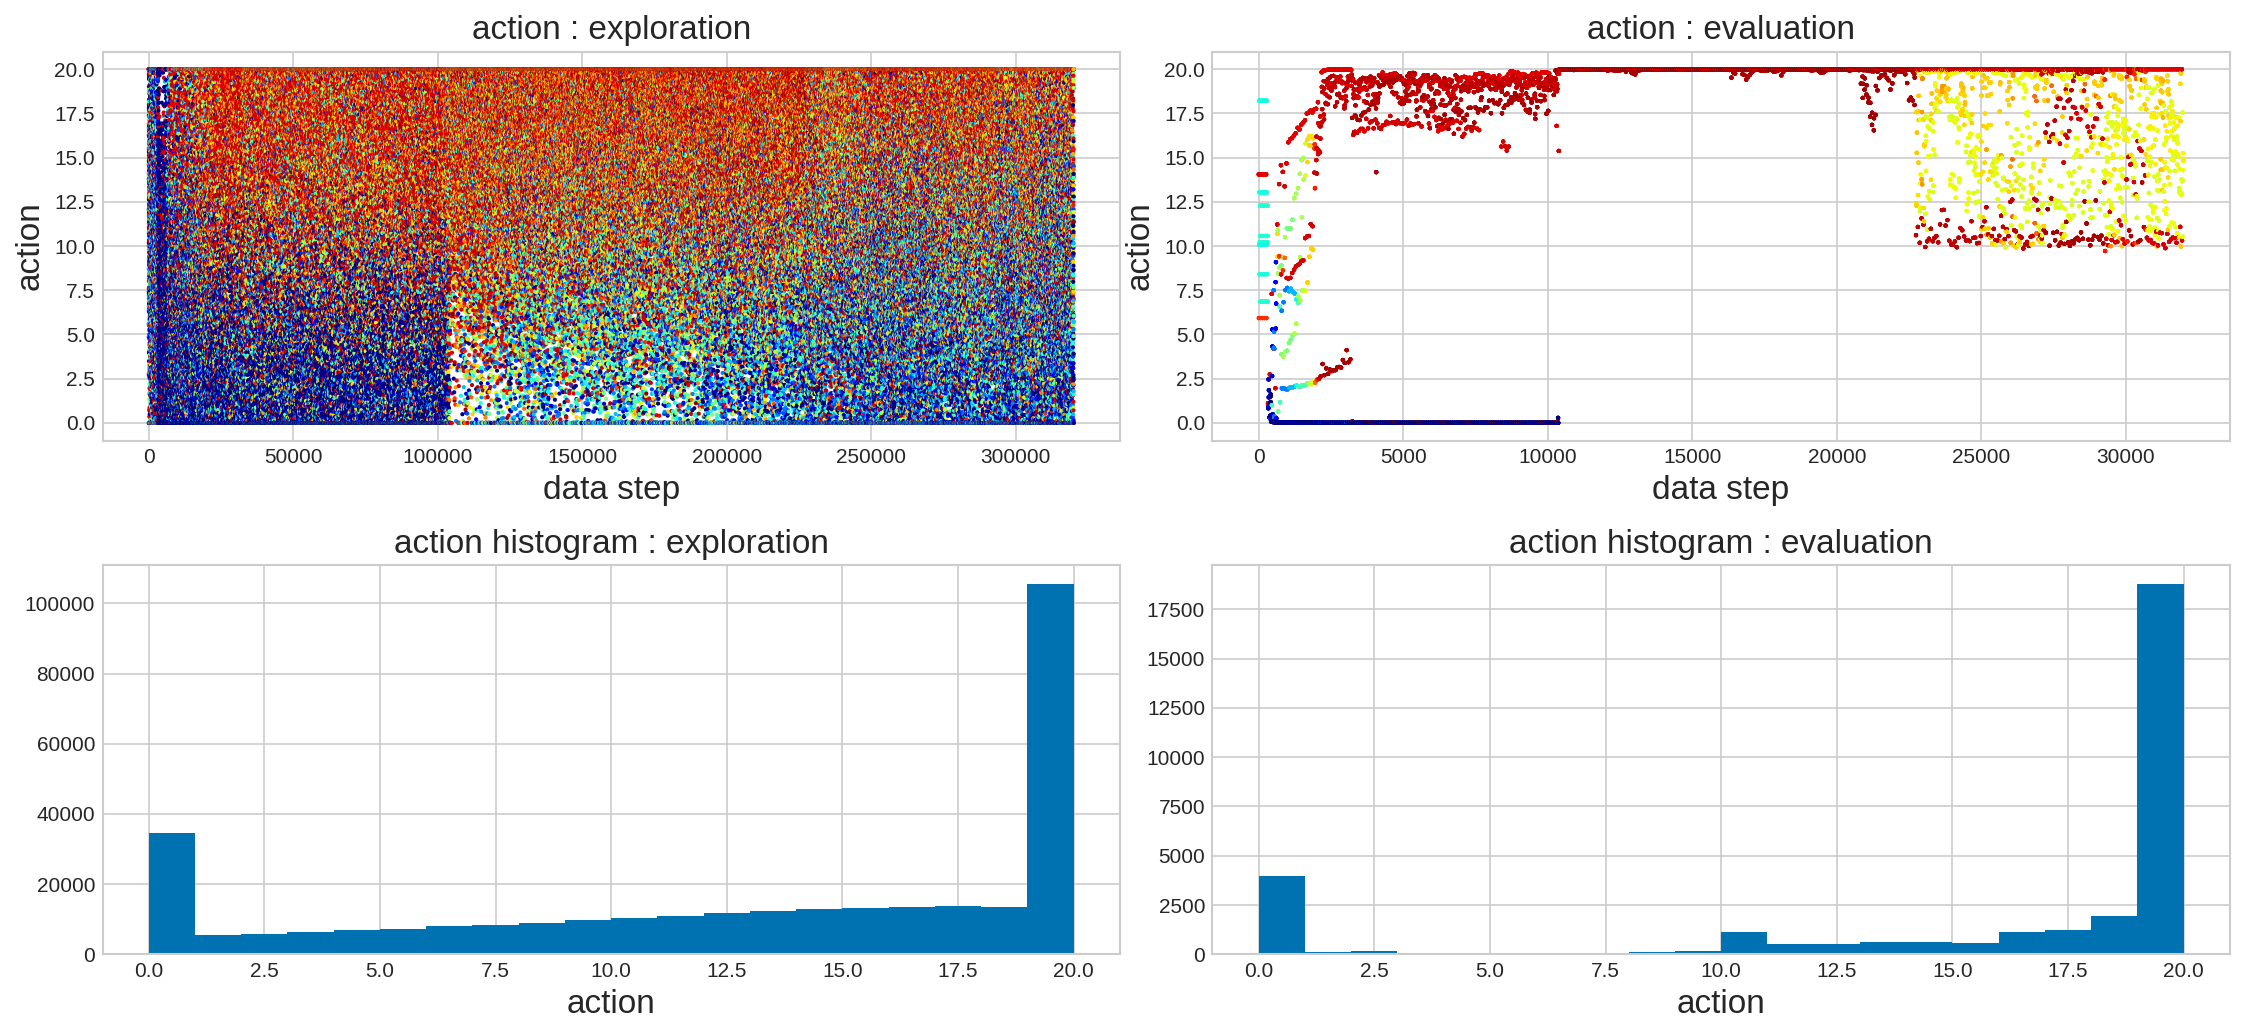

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


bankrupt=1438380, total=1760064, ratio=0.8172


In [8]:
import DDPG  # original DRL code
importlib.reload(DDPG)
from keras import optimizers

action_min = mu_min
action_max = mu_max
sigma_max = (action_max - action_min) / 3

model_policy = DDPG.gen_model_policy(state_shapes=env.shapes(), n_actions=1, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG.gen_model_value(state_shapes=env.shapes(), n_actions=1, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False,], [1.0,], [10,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))
    
    tester = DDPG.Tester(env, model_policy, model_value, val_min=action_min, val_max=action_max)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                gamma=1.0/(1+hurdle),
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                wampup_steps=500, 
                get_log=True)

    viz = DDPG.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(trainer=tester.trainer, 
                      state_valuation=lambda x:np.ravel(x[0][:, 0]), 
                      action_valuation=lambda x:np.ravel(x[:, 0]),
                      data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

lr_p=0.0001, lr_v=0.001, boltzmann=False, sigma_end=1.0, tau_end=10
start testing... :  2019-11-09 02:15:42.690106
start 0/5 th trial...


100%|██████████| 50000/50000 [24:52<00:00, 23.24it/s]


start 1/5 th trial...


100%|██████████| 50000/50000 [25:28<00:00, 32.72it/s]


start 2/5 th trial...


100%|██████████| 50000/50000 [25:53<00:00, 32.18it/s]


start 3/5 th trial...


100%|██████████| 50000/50000 [26:23<00:00, 23.85it/s]


start 4/5 th trial...


100%|██████████| 50000/50000 [26:56<00:00, 22.15it/s]


end testing... :  2019-11-09 04:25:48.643767
loss and reward history


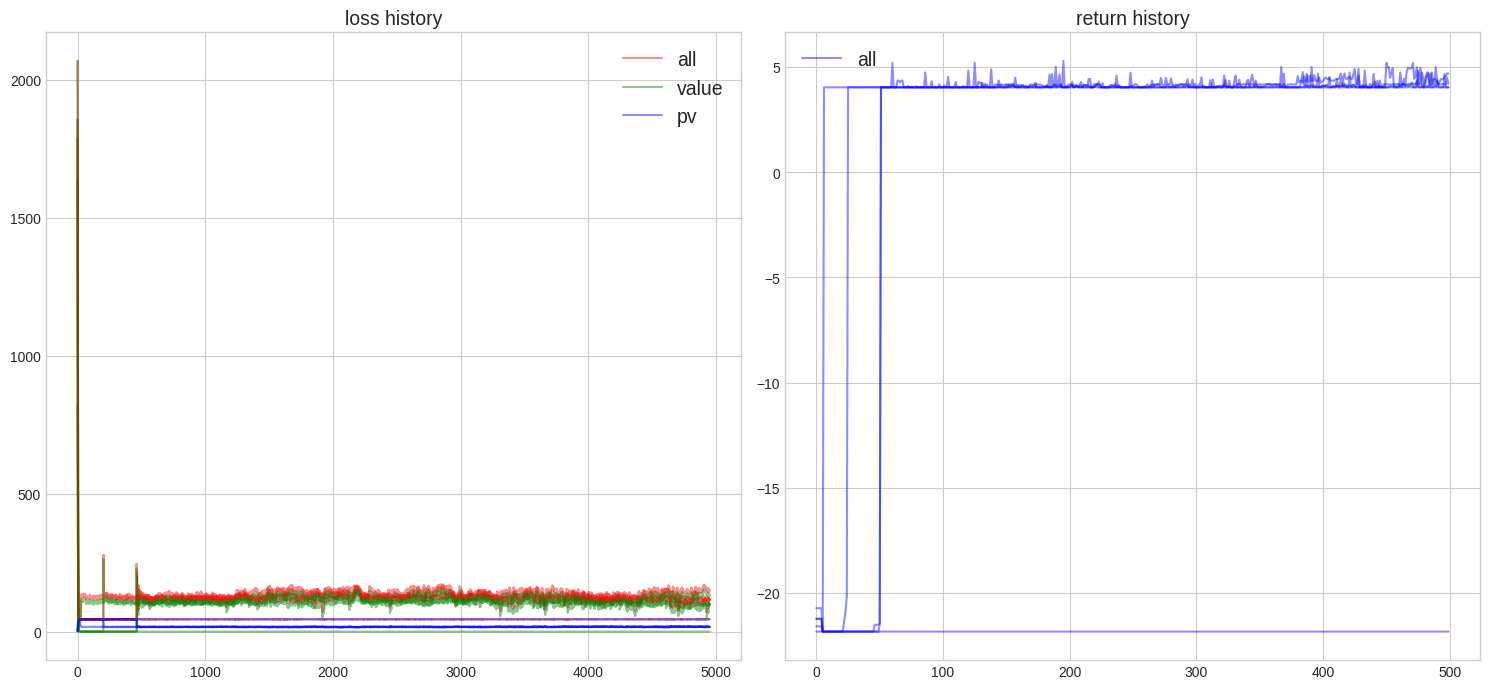

acquired action
action =  [19.991 19.991 19.991 19.991 19.991 19.991 19.991 19.991 19.991 19.991]
action =  [14.801 14.801 14.801 14.801 14.801 14.801 14.801 14.801 14.801 14.801]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [10.508 10.508 10.508 10.508 10.508 10.508 10.508 10.508 10.508 10.508]
return [4.204 4.204 4.204 4.204 4.204 4.204 4.204 4.204 4.204 4.204]
param distribution in model_policy


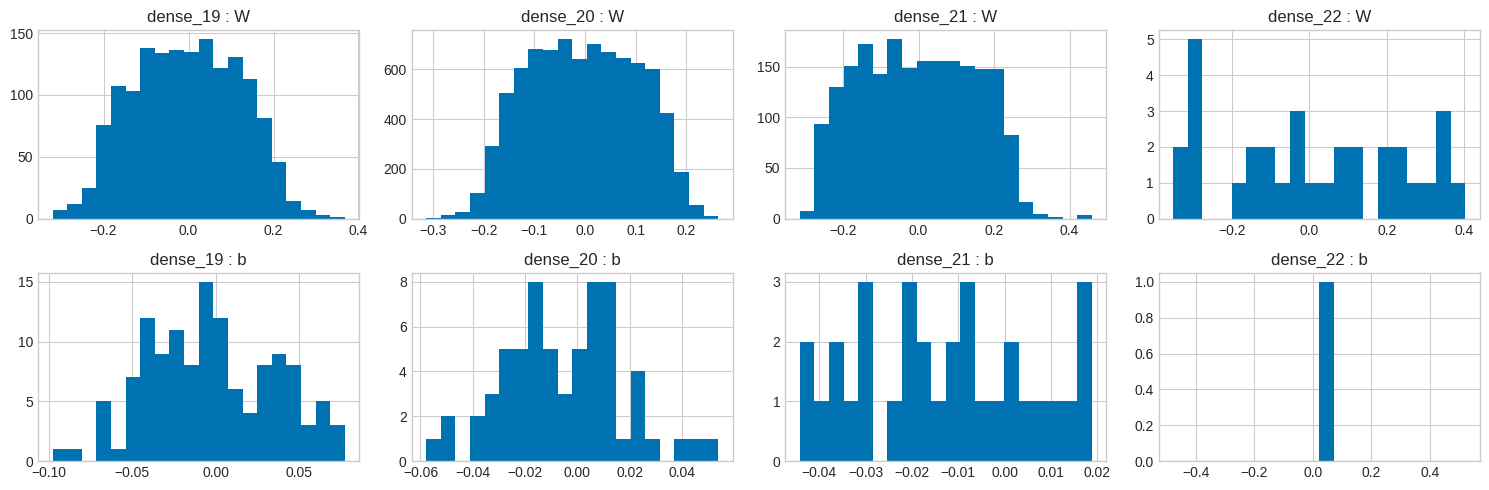

param distribution in model_value


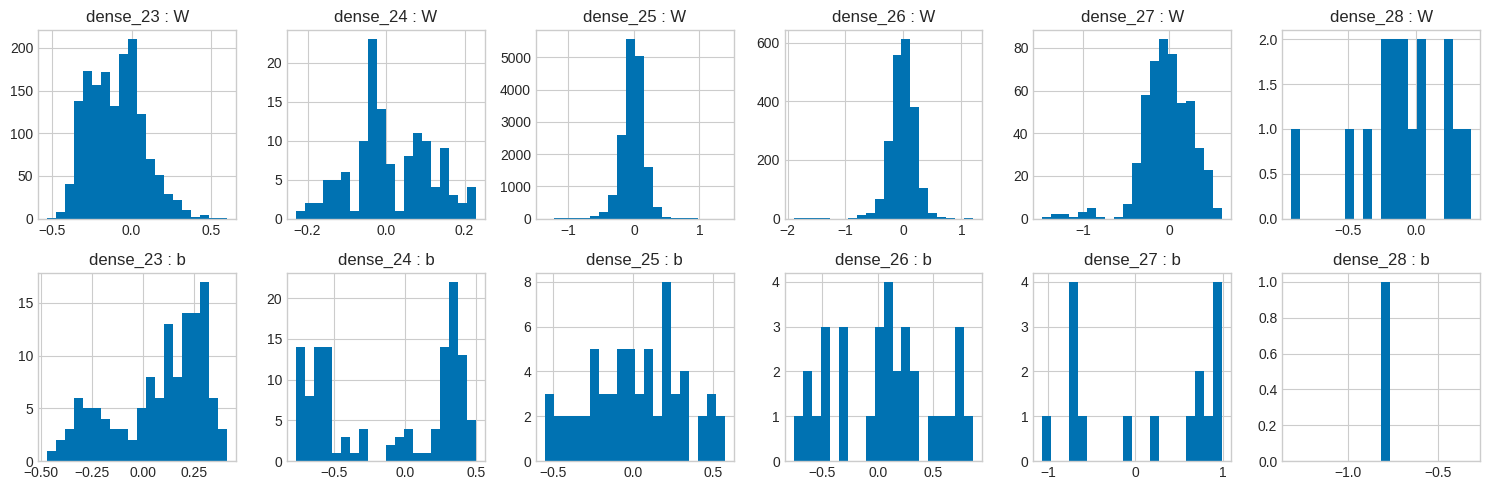

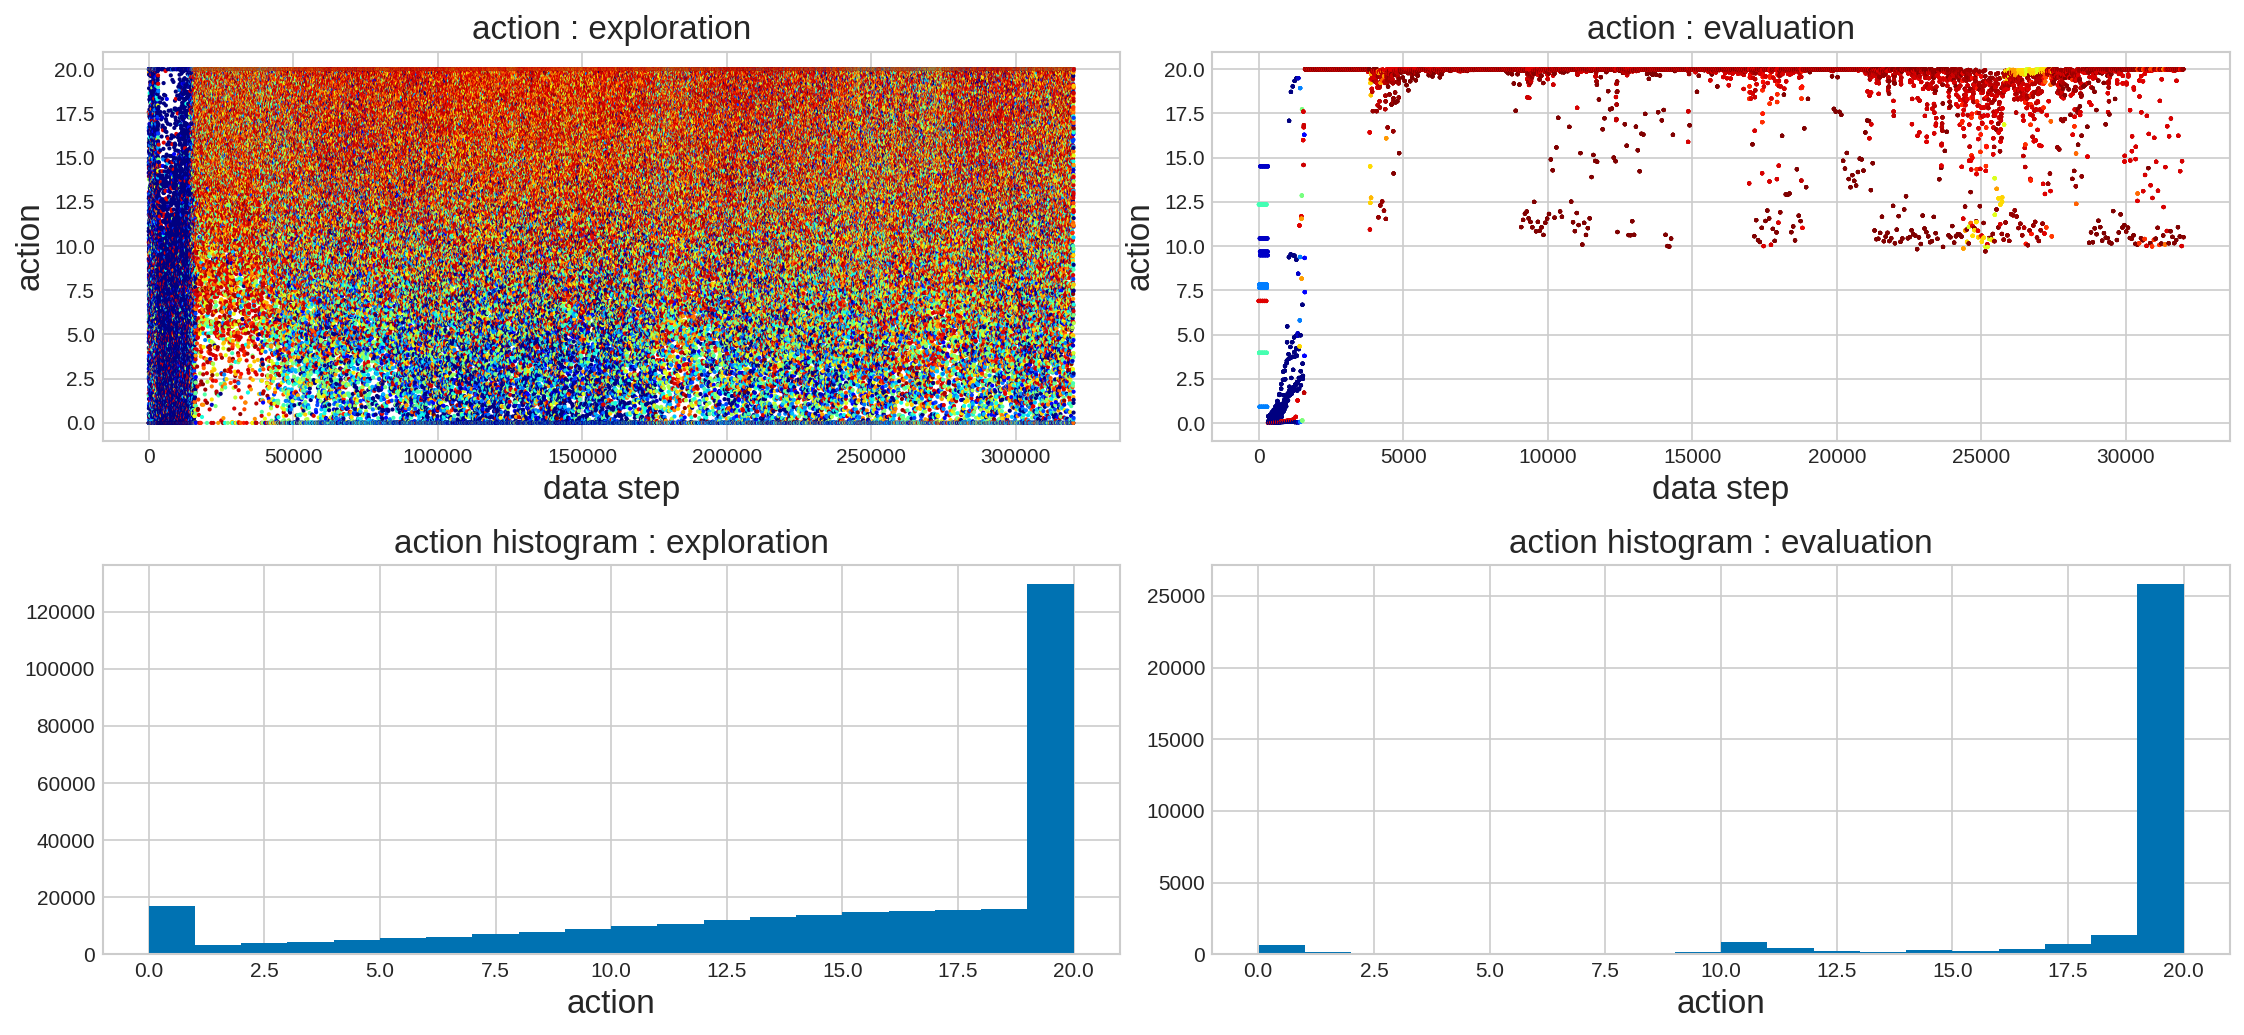

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


bankrupt=1158183, total=1760064, ratio=0.6580


In [9]:
import DDPG_SER  # original DRL code
importlib.reload(DDPG_SER)
from keras import optimizers

action_min = mu_min
action_max = mu_max
sigma_max = (action_max - action_min) / 3

model_policy = DDPG_SER.gen_model_policy(state_shapes=env.shapes(), n_actions=1, 
                                     hidden_dims=[128, 64, 32], 
                                     reg_l1=0.0, reg_l2=0.0, 
                                     action_min=action_min, action_max=action_max, 
                                     batch_norm_input=False, 
                                     state_reg=False, state_min=0, state_max=10)

model_value = DDPG_SER.gen_model_value(state_shapes=env.shapes(), n_actions=1, \
                                   hidden_action_dims=[128,], 
                                   hidden_state_dims=[128,],
                                   hidden_dims=[64, 32, 16],
                                   reg_l1=0.0, reg_l2=0.0,
                                   batch_norm_state_hidden=False)


#df = pd.DataFrame()
for lr_p, lr_v, boltzmann, sigma_end, tau_end in itertools.product(
    [1e-4,], [1e-3,], [False,], [1.0,], [10,]):
    print('======================================================')
    print('lr_p={}, lr_v={}, boltzmann={}, sigma_end={}, tau_end={}'
          .format(lr_p, lr_v, boltzmann, sigma_end, tau_end))
    
    tester = DDPG_SER.Tester(env, model_policy, model_value, val_min=action_min, val_max=action_max)
    #n_trials = 5
    #n_steps = 10000
    tester.test(n_trials=n_trials,
                n_steps=n_steps, training_interval=10, n_batches=10, batch_size=256,
                target_update_interval_policy=20, target_update_interval_value=20,
                tau_policy=0.5, tau_value=0.5,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0/(1+hurdle),
                optimizer_pv=optimizers.Adam(lr=lr_p), optimizer_value=optimizers.Adam(lr=lr_v),
                sigma_start=sigma_max, sigma_end=sigma_max*sigma_end, sigma_interval=n_steps,
                boltzmann=boltzmann, tau_start=10, tau_end=tau_end, tau_interval=n_steps, n_samples=64,
                policy_sampling_update=False, policy_sampling_n=64,
                policy_sampling_sigma_start=10.0, policy_sampling_sigma_end=1.0, policy_sampling_sigma_interval=n_steps,
                warmpup_steps=500,
                n_advantages=10, 
                category_weights={'bankrupt':0.5, 'ok':0.5}, default_weight=1.0, 
                verbose=False, verbose_interval=10, evaluate_interval=100,
                get_log=True, save_objects=False)

    viz = DDPG_SER.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                               cmap='jet', alpha=1.0, s=1.0)
    viz.viz_Q_history(trainer=tester.trainer, 
                      state_valuation=lambda x:np.ravel(x[0][:, 0]), 
                      action_valuation=lambda x:np.ravel(x[:, 0]),
                      data_span_exp=100, data_span_eva=100,)
    
    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr_p'] = lr_p
        #df_temp['lr_v'] = lr_v
        #df_temp['boltzmann'] = boltzmann
        #df_temp['sigma_end'] = sigma_end
        #df_temp['tau_end'] = tau_end
        df_temp['Agent'] = 'DDPG_SER'

        df = pd.concat([df, df_temp])

    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0
    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)

df.to_csv(tester.name + '.csv')

---
### AWR

lr=0.0001, mult_critic=1.0, mult_entropy=0.001
start testing... :  2019-11-09 04:26:43.596688
start 0/5 th trial...


  1%|          | 480/50000 [00:02<1:17:01, 10.71it/s] W1109 04:26:48.644707 140184961824576 deprecation.py:323] From /home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 50000/50000 [07:34<00:00, 109.96it/s]


start 1/5 th trial...


100%|██████████| 50000/50000 [07:38<00:00, 106.43it/s]


start 2/5 th trial...


100%|██████████| 50000/50000 [07:45<00:00, 107.35it/s]


start 3/5 th trial...


100%|██████████| 50000/50000 [07:44<00:00, 107.63it/s]


start 4/5 th trial...


100%|██████████| 50000/50000 [07:48<00:00, 106.81it/s]


end testing... :  2019-11-09 05:05:28.471366
loss and reward history


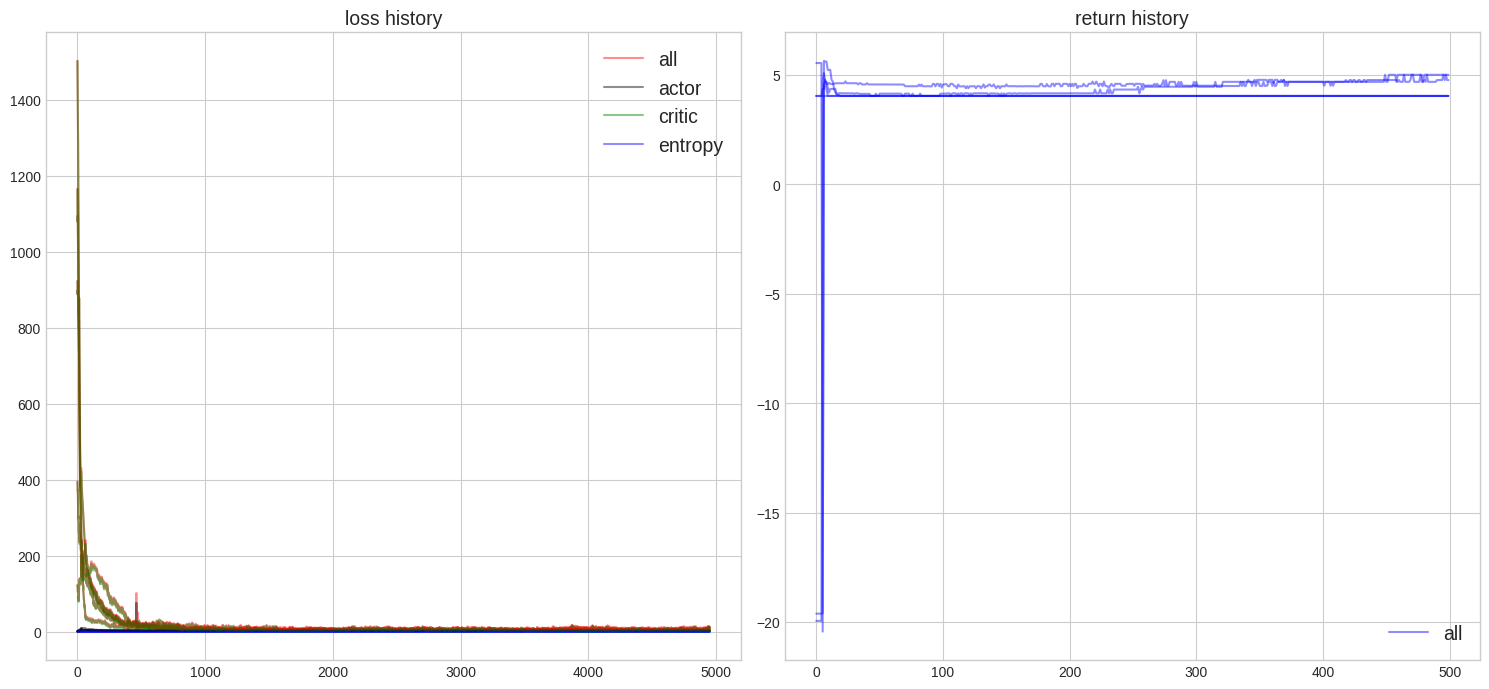

acquired action
action =  [19.999 19.999 19.999 19.999 19.999 19.999 19.999 19.999 19.999 19.999]
action =  [19.999 19.999 19.999 19.999 19.999 19.999 19.999 19.999 19.999 19.999]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
return [4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033]
param distribution in model


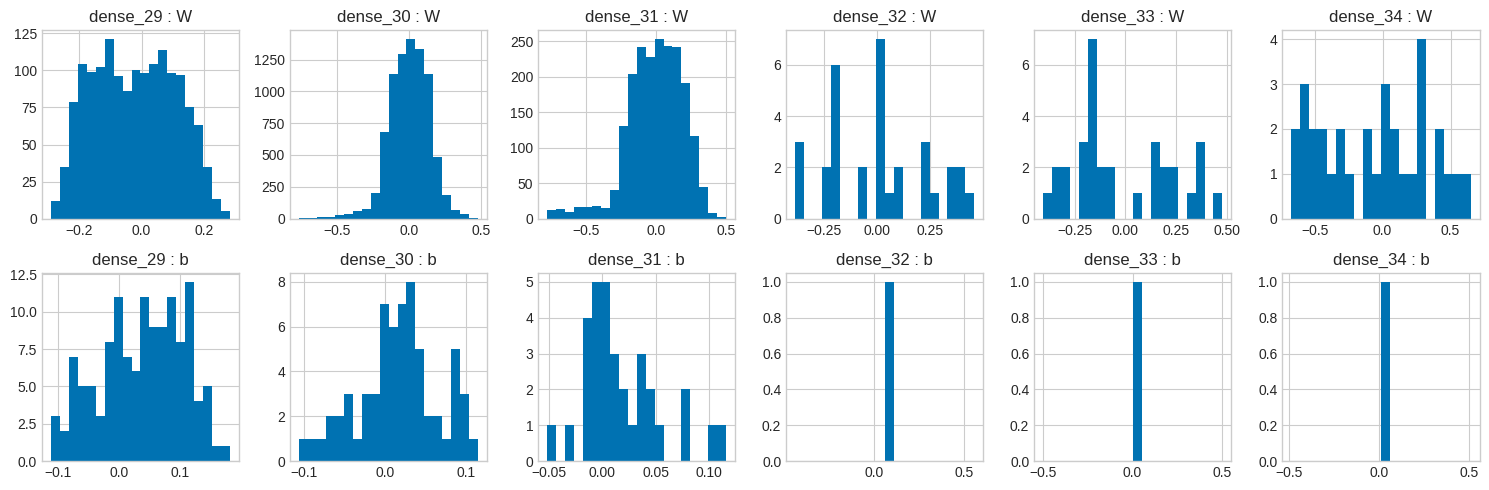

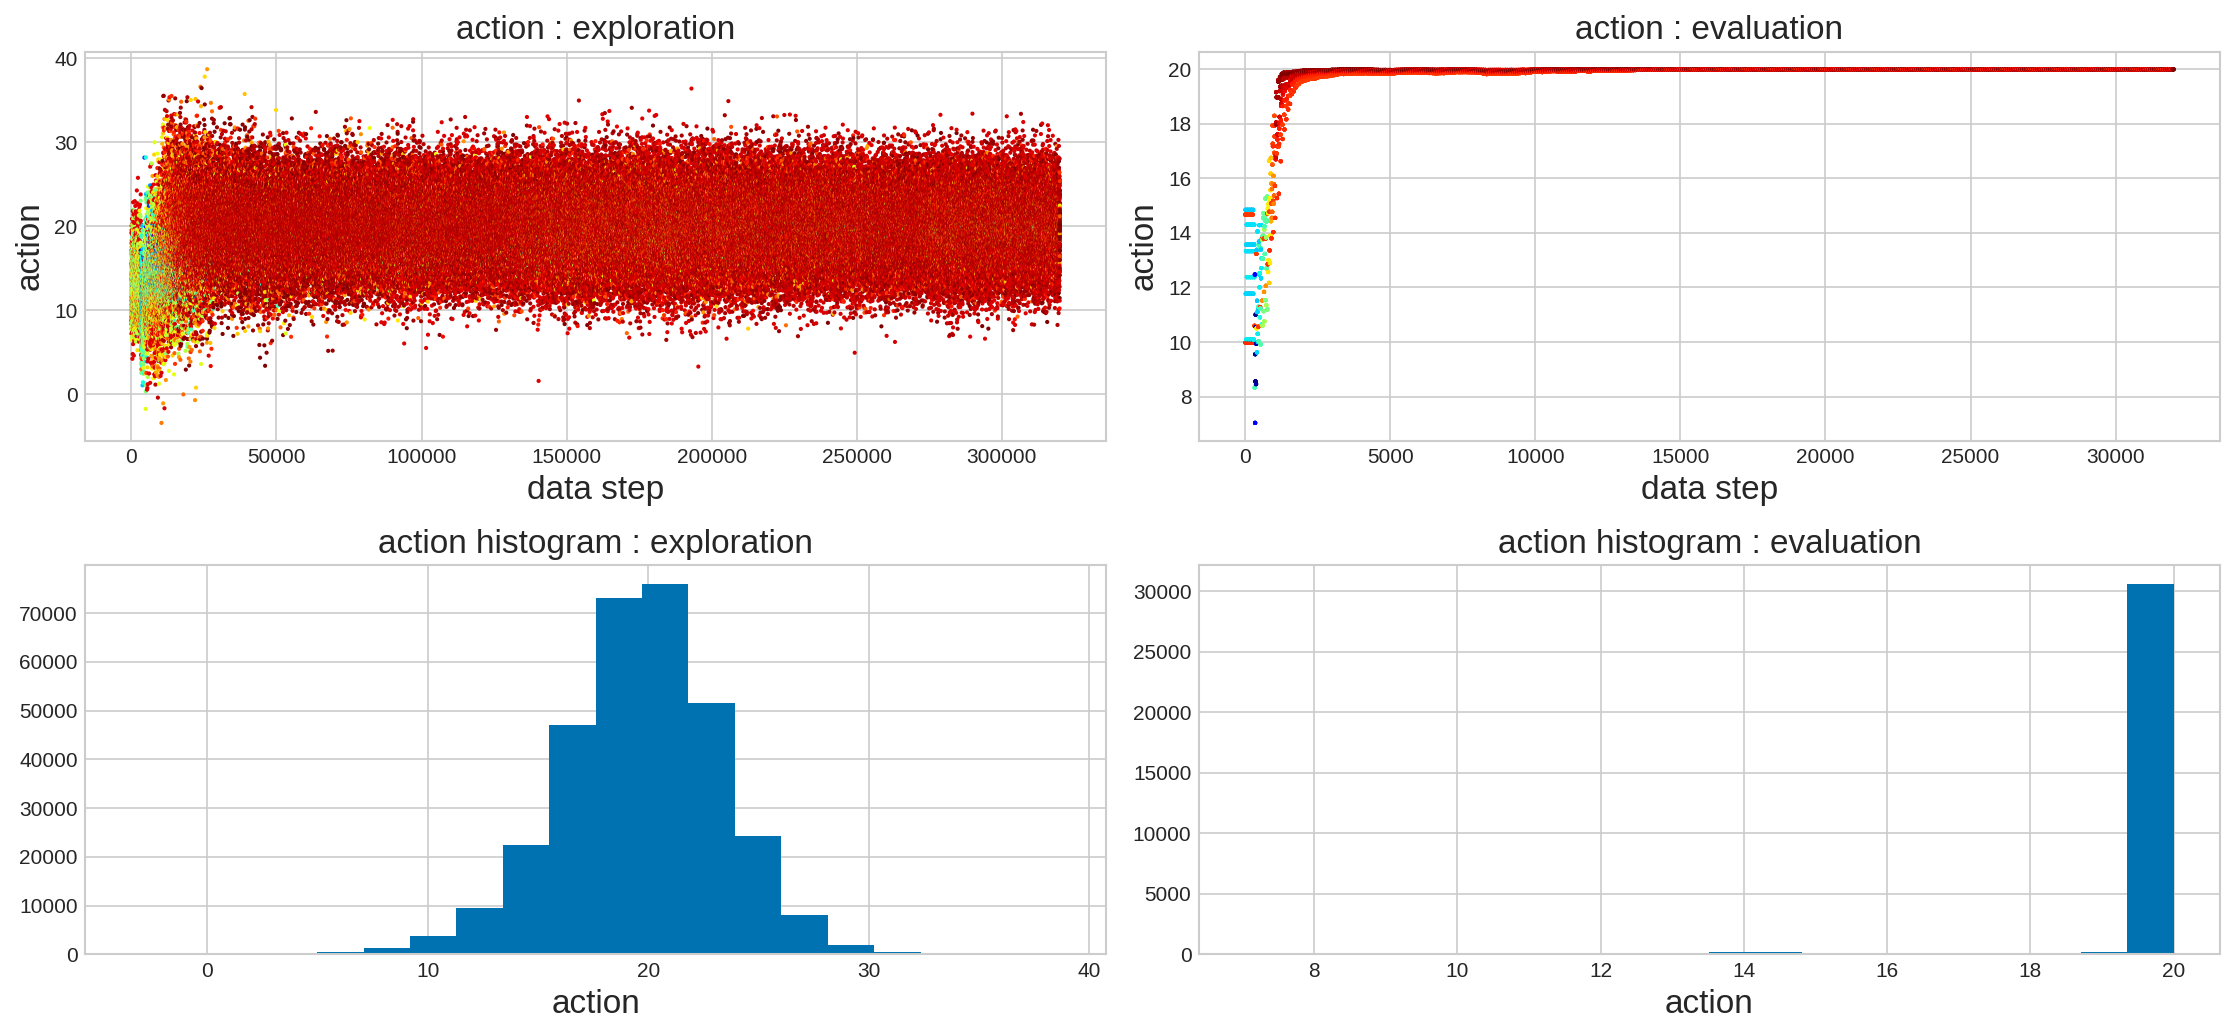

bankrupt=52694, total=1760065, ratio=0.0299


In [10]:
import AWR
importlib.reload(AWR)  # original DRL code

from keras import optimizers

env = Env_Reserve_RB.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=False, 
                              n_agents=64)

mu_min = mu_min
mu_max = mu_max
sigma_max = (mu_max - mu_min) / 3

model = AWR.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                      hidden_dims=[128, 64, 32], reg_l1=1e-6, reg_l2=1e-6, \
                      state_reg=False, state_min=-1.0, state_max=1.0,
                      action_reg=True, 
                      action_min=mu_min, action_max=mu_max, 
                      action_sigma_min=0.0001, action_sigma_max=sigma_max, 
                      value_reg=False, value_min=0, value_max=1)

#df = pd.DataFrame()
for lr, mult_critic, mult_entropy in itertools.product(
    [1e-4,], [1.0,], [1e-3,]):
    print('======================================================')
    print('lr={}, mult_critic={}, mult_entropy={}'
          .format(lr, mult_critic, mult_entropy))
    
    tester = AWR.Tester(env, model, 
                        action_min=mu_min-3*sigma_max, 
                        action_max=mu_max+3*sigma_max)
    #n_trials = 1
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, 
                training_interval=10, n_batches=10, batch_size=256,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0/(1+hurdle), 
                optimizer=optimizers.Adam(lr=lr, clipnorm=10.0, clipvalue=10.0),
                mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy, mult_beta=10.0, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = AWR.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'AWR'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

lr=0.0001, mult_critic=1.0, mult_entropy=0.001
start testing... :  2019-11-09 05:05:38.115242
start 0/5 th trial...


100%|██████████| 50000/50000 [08:32<00:00, 97.59it/s] 


start 1/5 th trial...


100%|██████████| 50000/50000 [08:58<00:00, 92.82it/s] 


start 2/5 th trial...


100%|██████████| 50000/50000 [09:20<00:00, 87.65it/s] 


start 3/5 th trial...


100%|██████████| 50000/50000 [09:07<00:00, 91.28it/s] 


start 4/5 th trial...


100%|██████████| 50000/50000 [09:04<00:00, 83.90it/s] 


end testing... :  2019-11-09 05:50:59.155183
loss and reward history


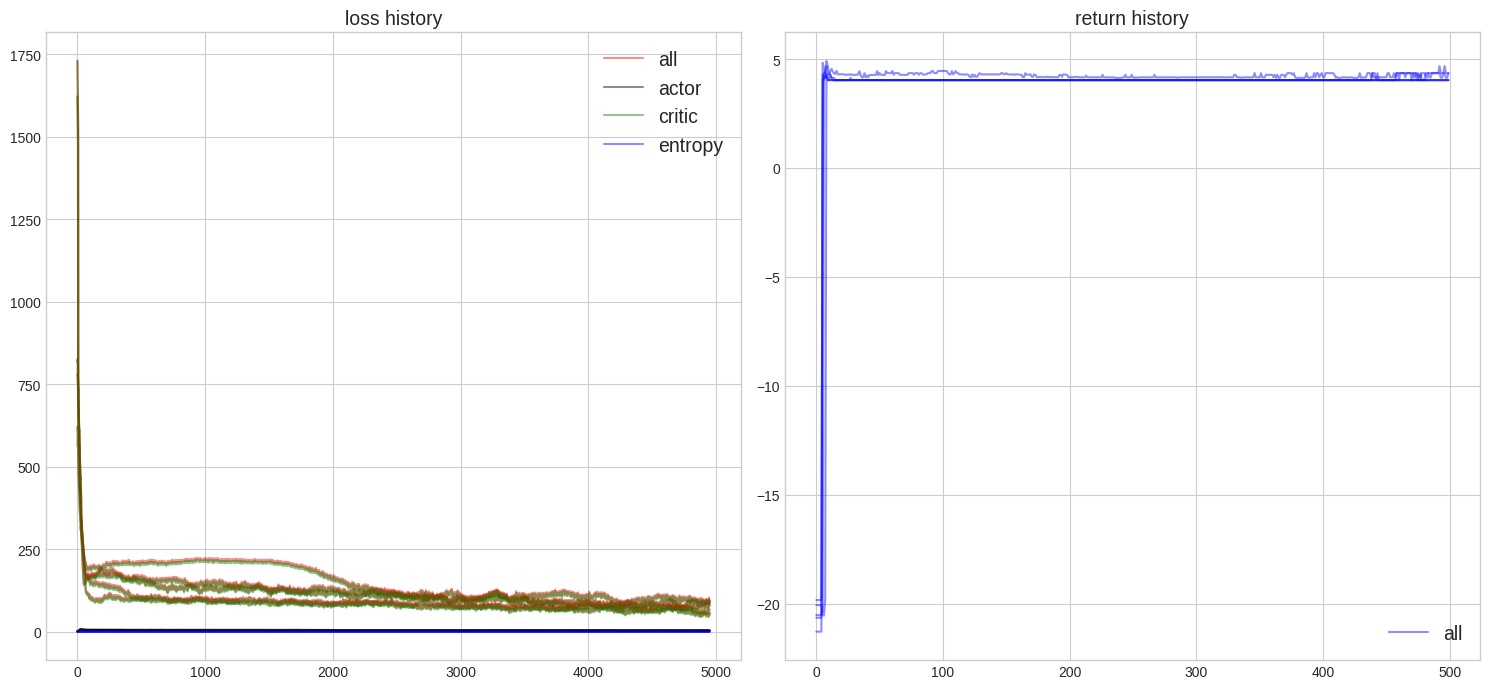

acquired action
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
action =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
return [4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033 4.033]
param distribution in model


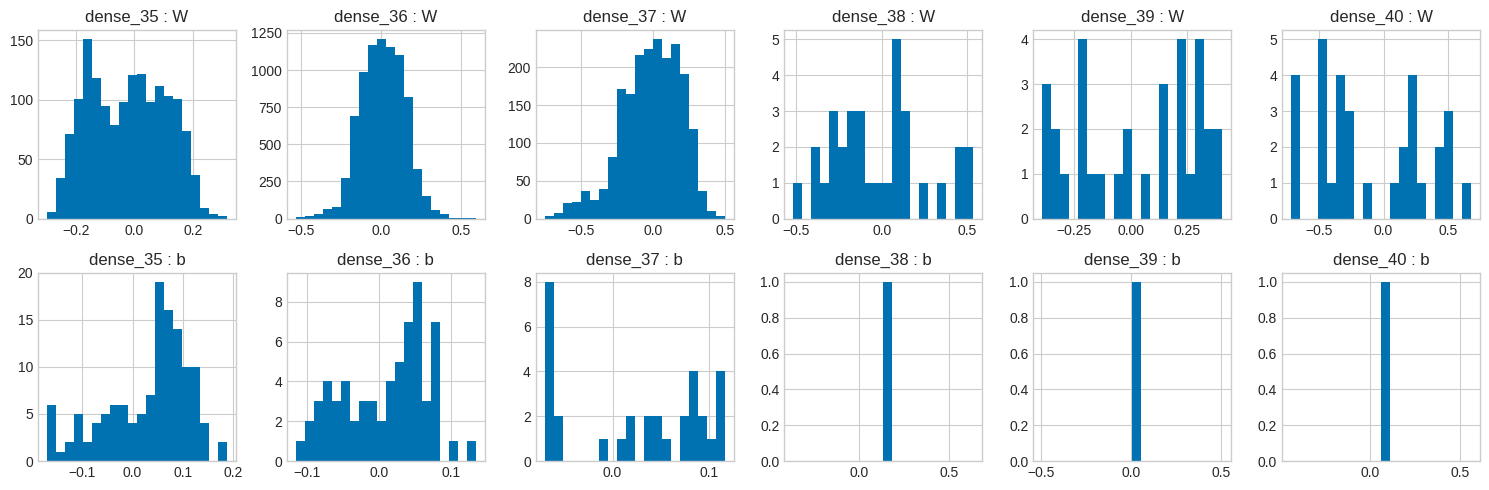

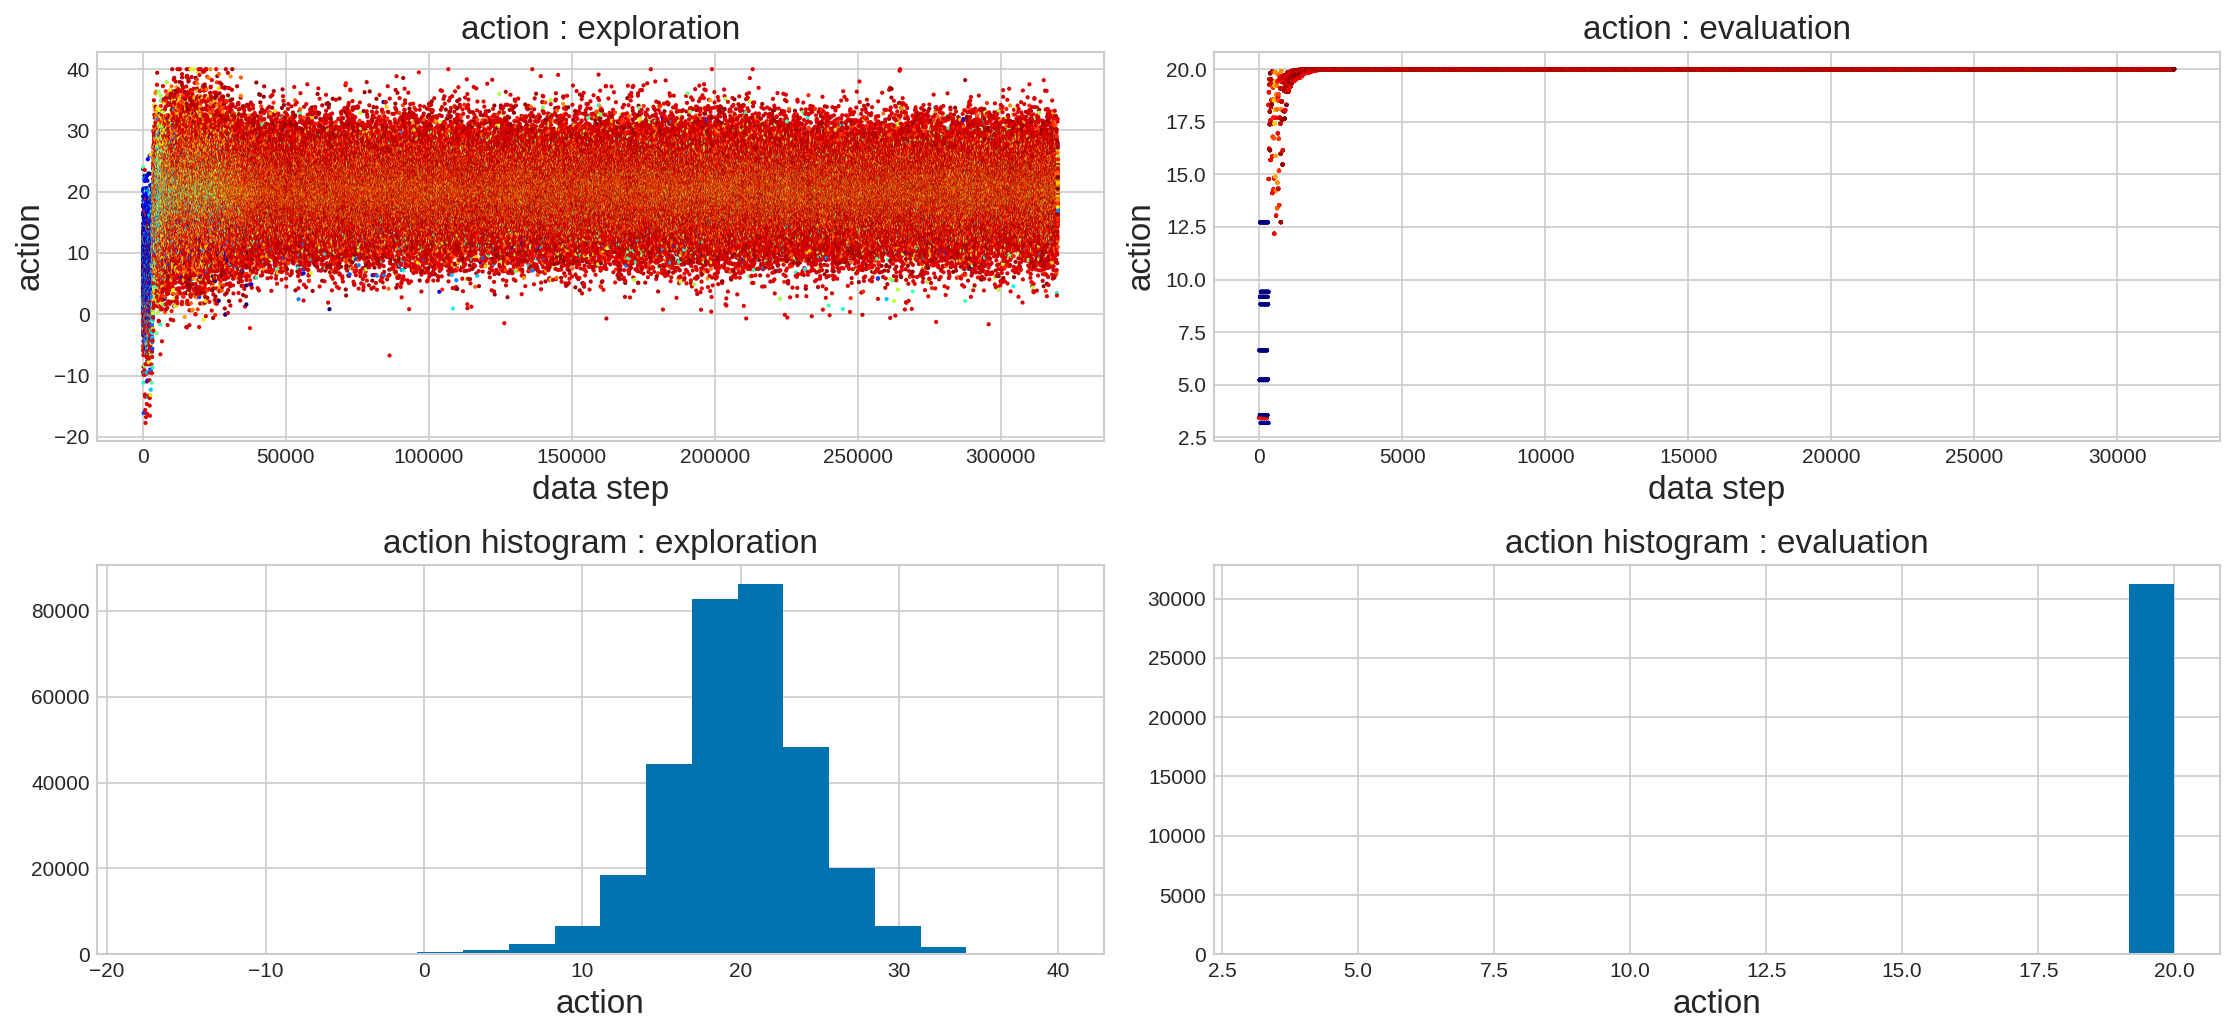

bankrupt=169450, total=1763566, ratio=0.0961


In [11]:
import AWR
importlib.reload(AWR)  # original DRL code

from keras import optimizers

env = Env_Reserve_RB.Environment(cashflow=cashflow, 
                              interest=interest, hurdle=hurdle, 
                              initial_cash=initial_cash, bankrupt_penalty=bankrupt_penalty, 
                              bankrupt_info=True, 
                              n_agents=64)

mu_min = mu_min
mu_max = mu_max
sigma_max = (mu_max - mu_min) / 3

model = AWR.gen_model(input_shapes=env.shapes(), n_outputs=1, \
                      hidden_dims=[128, 64, 32], reg_l1=1e-6, reg_l2=1e-6, \
                      state_reg=False, state_min=-1.0, state_max=1.0,
                      action_reg=True, 
                      action_min=mu_min, action_max=mu_max, 
                      action_sigma_min=0.0001, action_sigma_max=sigma_max, 
                      value_reg=False, value_min=0, value_max=1)

#df = pd.DataFrame()
for lr, mult_critic, mult_entropy in itertools.product(
    [1e-4,], [1.0,], [1e-3,]):
    print('======================================================')
    print('lr={}, mult_critic={}, mult_entropy={}'
          .format(lr, mult_critic, mult_entropy))
    
    tester = AWR.Tester(env, model, 
                        action_min=mu_min-3*sigma_max, 
                        action_max=mu_max+3*sigma_max)
    #n_trials = 1
    #n_steps = 10000
    tester.test(n_trials=n_trials, n_steps=n_steps, 
                training_interval=10, n_batches=10, batch_size=256,
                buf_alpha=0.5, buf_beta=0.5, buf_mode='rank',
                gamma=1.0/(1+hurdle), 
                optimizer=optimizers.Adam(lr=lr, clipnorm=10.0, clipvalue=10.0),
                mult_actor=1.0, mult_critic=mult_critic, mult_entropy=mult_entropy, mult_beta=10.0, 
                category_weights={'bankrupt':0.5, 'ok':0.5}, default_weight=1.0, 
                verbose=False, verbose_interval=100, evaluate_interval=100, 
                get_log=True)

    viz = AWR.Visualizer()
    viz.viz_action_history(tester.trainer, state_valuation=lambda x:x[0], action_valuation=lambda x:x, 
                           cmap='jet', alpha=1.0, s=1.0)

    for trial in range(n_trials):
        df_temp = pd.DataFrame(np.ravel(tester.return_histories[trial]['all']), columns=['return'])
        df_temp['trial'] = trial
        df_temp['t'] = np.arange(len(df_temp))
        #df_temp['lr'] = lr
        #df_temp['mult_critic'] = mult_critic
        #df_temp['mult_entropy'] = mult_entropy
        df_temp['Agent'] = 'AWR_SER'

        df = pd.concat([df, df_temp])

    #ModelInspection.inspect_hidden_layers(tester.env, tester.model, tester.agent, show_hidden_hist=True)
    print('bankrupt={}, total={}, ratio={:.4f}'
      .format(env.done_bankrupt_counter, env.done_counter, env.done_bankrupt_counter/env.done_counter))
    env.done_counter = 0
    env.done_bankrupt_counter = 0

df.to_csv(tester.name + '.csv')

---
## 3. Results

In [12]:
pd.options.display.precision = 4
ids = ['Agent',]
df[df['t'].max()*0.9<=df['t']].groupby(ids)['return'].describe()

count    mean      std      min     25%     50%     75%     max
Agent                                                                    
AWR       250.0  4.3652   0.4180   4.0330  4.0330  4.0330  4.7577  4.9986
AWR_SER   250.0  4.1318   0.1486   4.0330  4.0330  4.0330  4.3549  4.6767
DDPG      250.0  5.2356   0.2702   4.1680  5.0871  5.2978  5.4679  5.5361
DDPG_SER  250.0 -0.9824  10.4500 -21.8348  4.0330  4.0380  4.1903  5.1990
DQN       250.0  4.6738   0.3324   4.0330  4.4189  4.6914  4.9651  5.3204
DQN_SER   250.0  5.3015   0.4035   4.0330  5.1127  5.3173  5.6423  5.7624

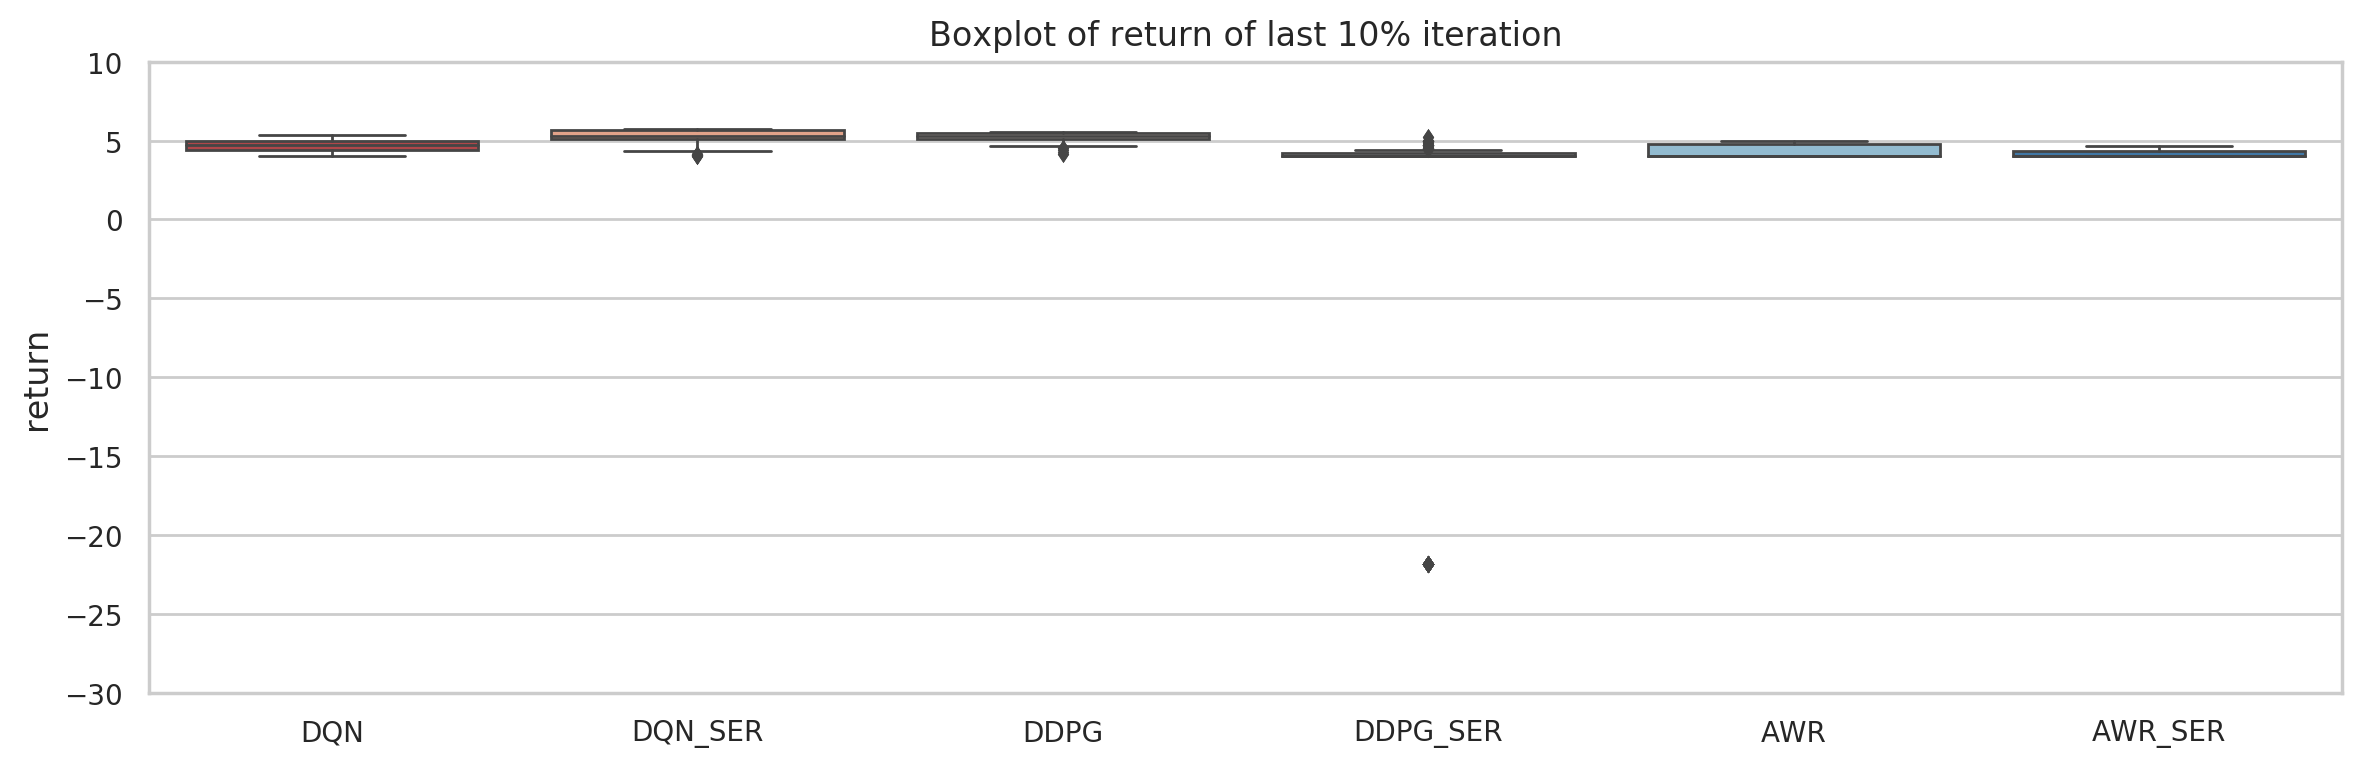

In [13]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[df['t'].max()*0.9<=df['t']], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.ylim(-30, 10)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

/home/deepstation/.pyenv/versions/anaconda3-5.0.1/envs/ForChainer/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


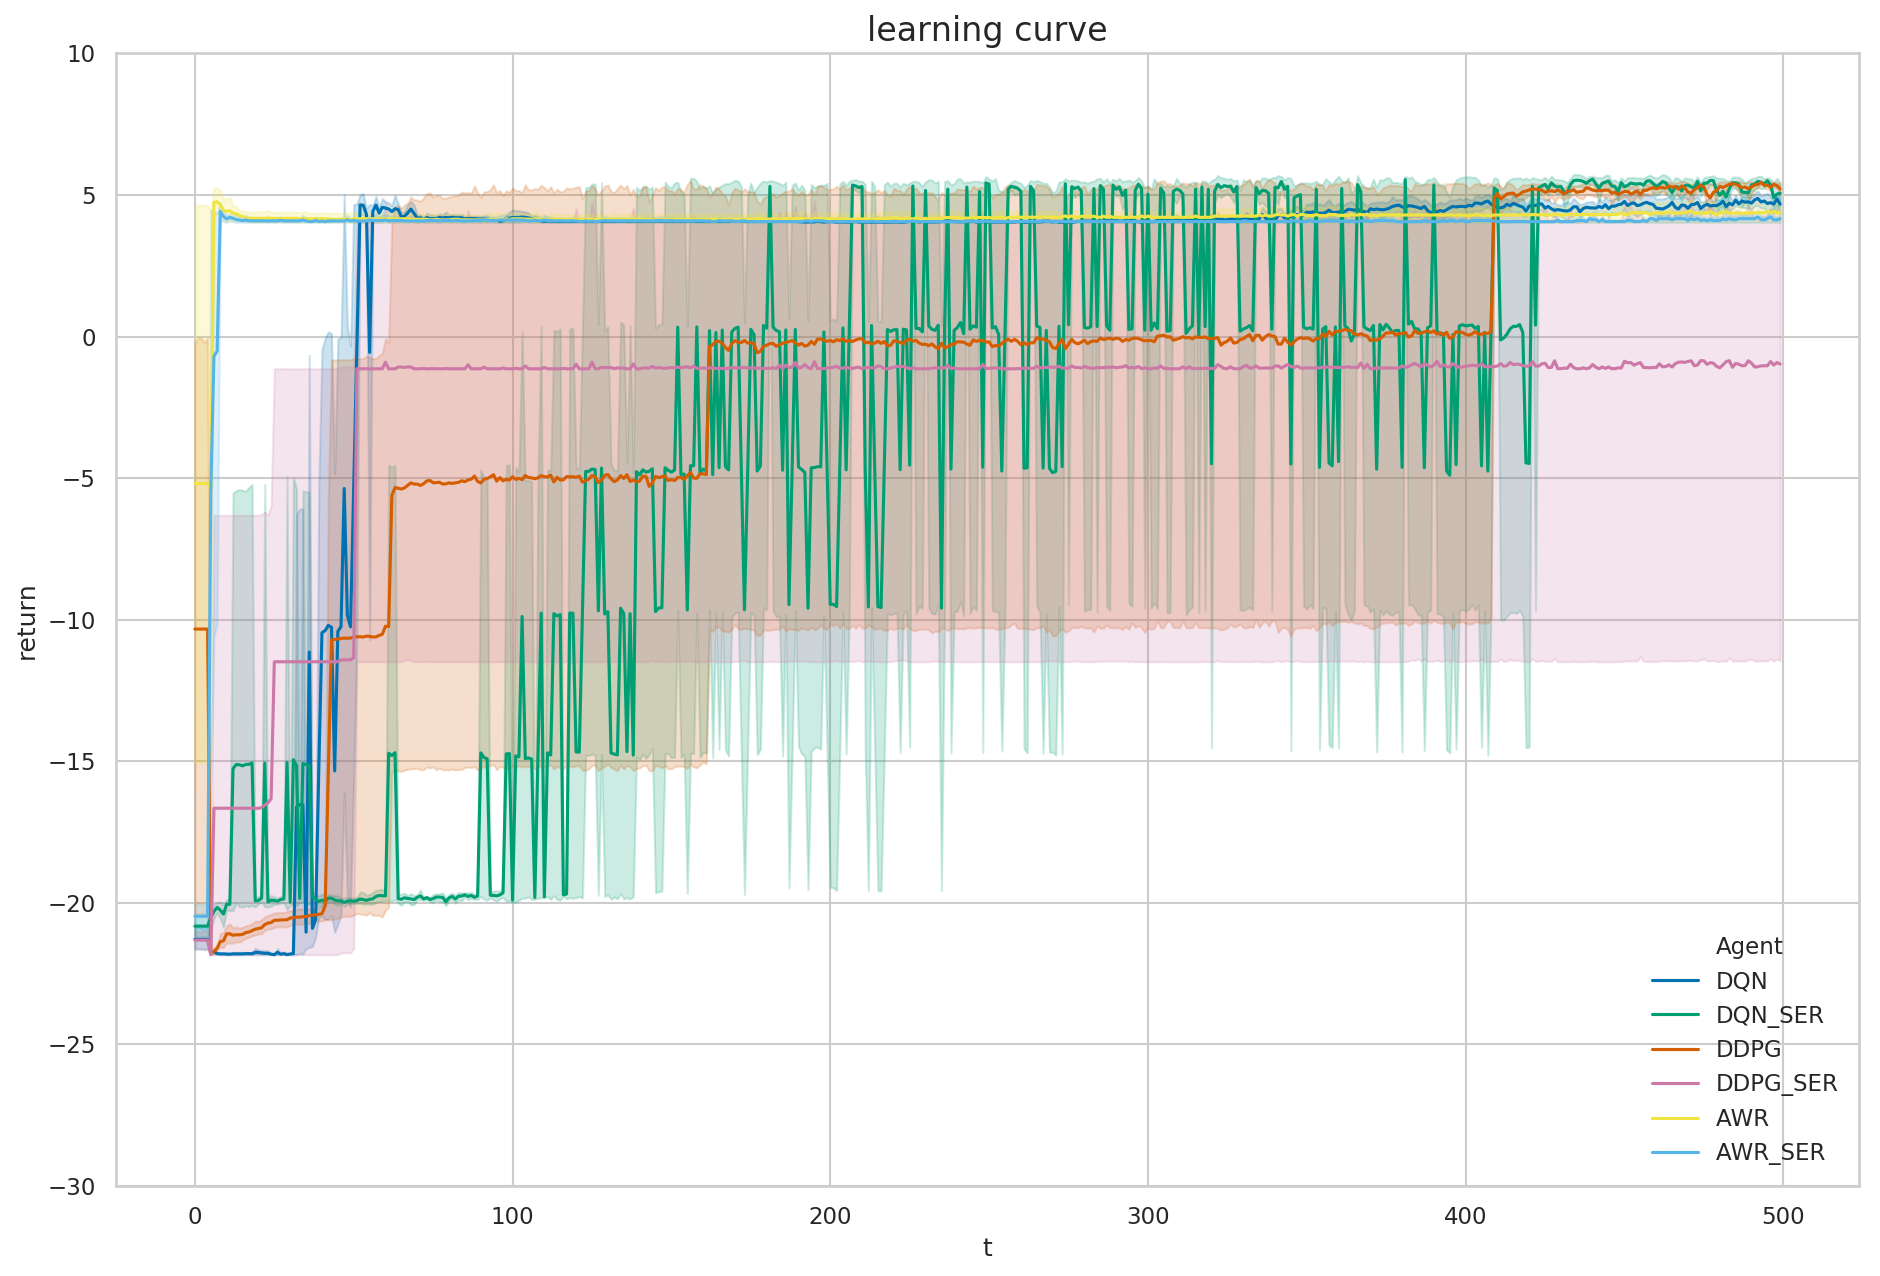

In [14]:
fig = plt.figure(figsize=(15, 10), dpi=150)
sns.lineplot(x='t', y='return', hue='Agent', data=df)
plt.ylim(-30, 10)
plt.title('learning curve', size=16)
plt.show()

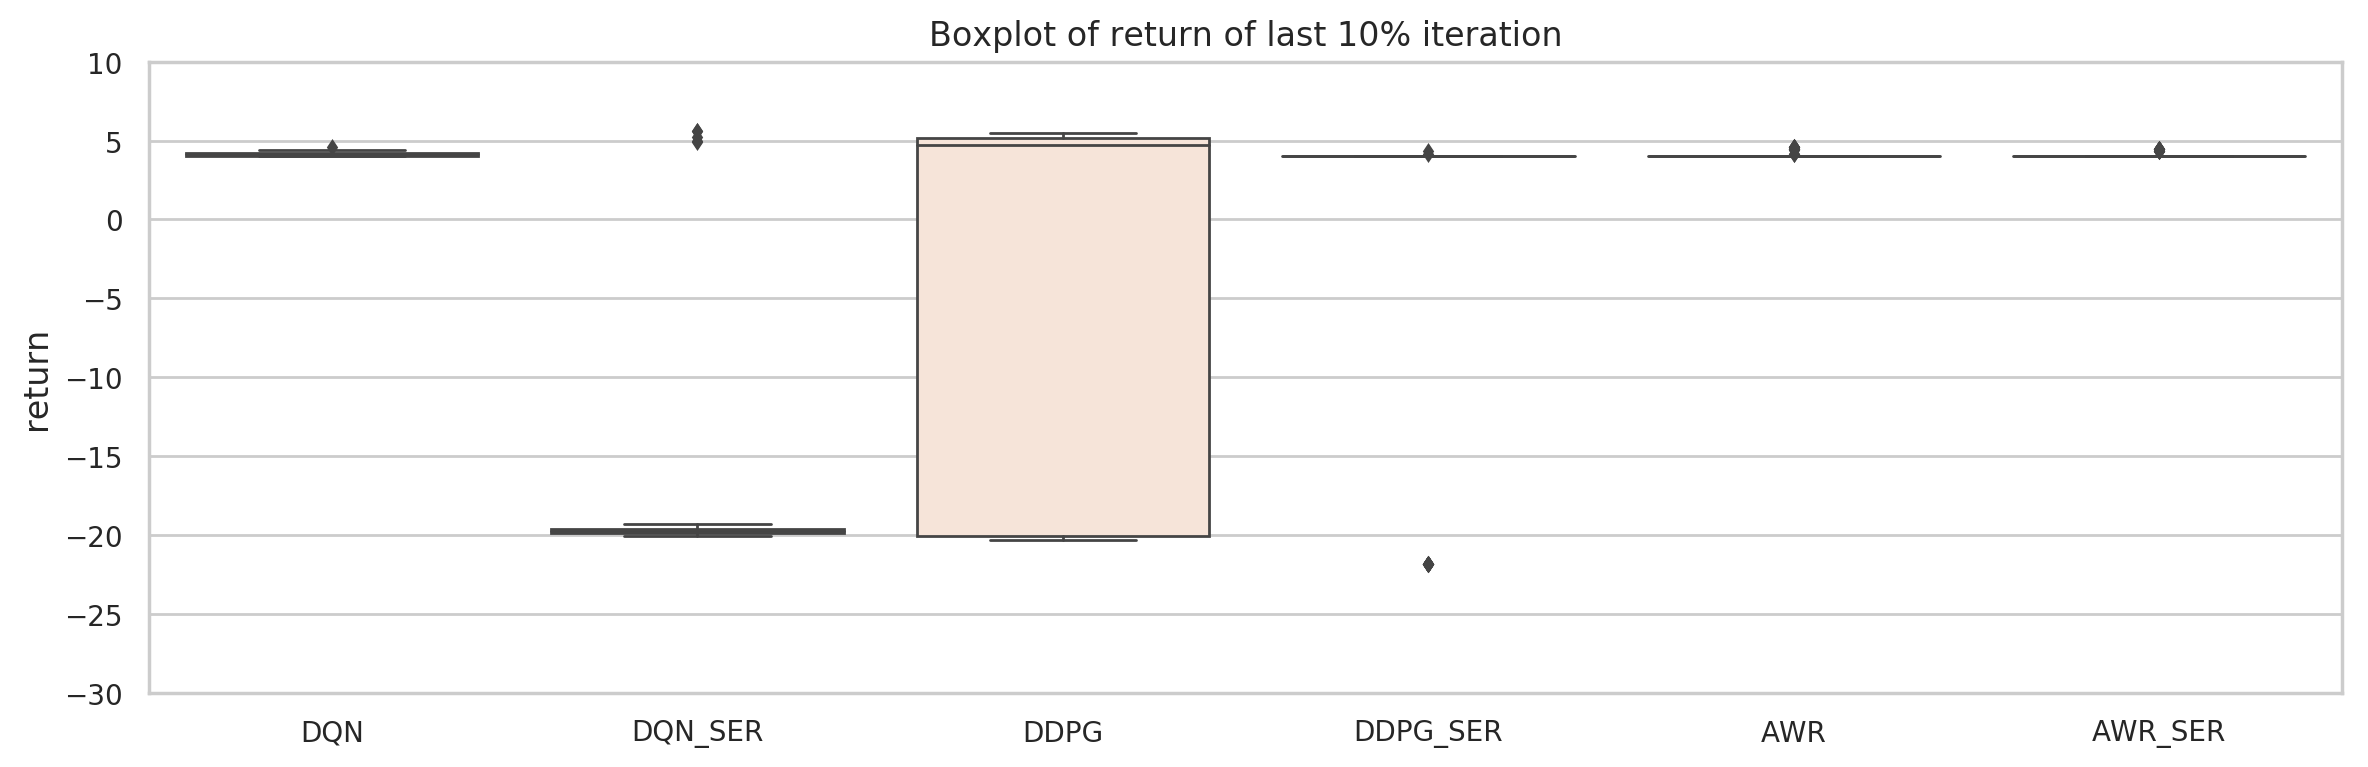

In [16]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(12, 4), dpi=200)

sns.boxplot(data=df[np.logical_and(df['t'].max()*0.9/5<=df['t'],
                                   df['t'].max()*1.0/5>=df['t'])], x='Agent', y='return', orient='v', fliersize=3.0, linewidth=1.0, palette='RdBu')

plt.title('Boxplot of return of last 10% iteration', fontsize=12)
plt.ylim(-30, 10)
plt.xlabel('', fontsize=12)
plt.ylabel('return', fontsize=12)
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()